# Project Report - Group 73

## **Using clinical features to predict likelihood of a stroke in patients**
#### Aden Chan, Matthew Chan, Shadib Hossain, Brian Vu

# Introduction
### Background
According to the National Cancer Institute, a stroke occurs when brain tissue is damaged by a loss of blood flow to certain parts of the brain (NIH). It is a significant global health issue, with an annual mortality rate of 5.5 million people worldwide, making it the second leading cause of death. Understanding the factors that contribute to stroke occurrence is crucial for prevention and effective treatment. Age is widely recognized as the strongest determinant of stroke risk, with the likelihood of experiencing a stroke doubling every decade after the age of 55. Additionally, hypertension has been identified as the leading risk factor of stroke in both developing and developed nations (Donker, 2018).

However, it is worth noting that there are other risk factors that exist, some of which are challenging to quantify accurately. These factors contribute to the complexity of predicting likelihood of a stroke. In light of this, our research question aims to address this challenge by **exploring the ability to accurately predict the likelihood of a stroke in a patient given a set of clinical features**.


To answer this research question, we will be utilizing the Stroke Prediction Dataset, available via Kaggle. The dataset comprises 5110 observations and contains 12 different variables which make up our clinical features for patients. These variables include gender, age, hypertension, heart disease, marriage status, type of work (self-employed/private/children/government/never worked), residence (rural or urban), average glucose levels, BMI, smoking status, and whether the patient has ever had a stroke.


By leveraging this dataset, we aim to identify patterns among these clinical features and the occurrence of stroke. This analysis will contribute to our understanding of the predictive power of these factors and potentially aid in the development of effective strategies for stroke prevention and management.

# Methodology & Results

Some preliminary steps prior to data analysis involves importing some dependencies and setting a `seed` for reproducible results. (Note: if you press "run all cells" everything will run, however it may take some time !)

In [58]:
#Import all dependencies
install.packages("ranger", dependencies=TRUE)
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(GGally)
library(broom)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [59]:
#Random Seed
set.seed(894235)

To conduct our data analysis, we will begin by demonstrating that the dataset can be loaded from its original source on Kaggle as a comma separated values file and can be read within R. 

In [60]:
#Create data dir and download csv into it
url <- "https://raw.githubusercontent.com/21chanas3/dsci100-group73/c9c58b88eca13be20286f8bf70dce4668b878247/data/healthcare-dataset-stroke-data.csv"
if (!dir.exists("data")) {
    dir.create("data")
}
download.file(url, "data/stroke.csv")

In [61]:
stroke <- read_csv("data/stroke.csv")

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We will next clean/wrangle our data into a tidy format - this involves the following steps: renaming of columns, converting the string “Unknown” into NA values, converting categorical variables into factors, renaming these factors into human-readable names, converting columns that should be numerical into doubles.

In [62]:
#Rename columns to all lowercase
stroke_colnames <- stroke |> colnames() |> make.names() |> tolower()
colnames(stroke) <- stroke_colnames

In [63]:
#Convert Unknown's to NA
stroke <- stroke |> na_if("Unknown")

#Convert categorical vars to factors
stroke <- stroke |> mutate(gender = as_factor(gender), 
                 work_type = as_factor(work_type), 
                 residence_type = as_factor(residence_type), 
                 smoking_status = as_factor(smoking_status),
                 hypertension = as_factor(hypertension),
                 ever_married = as_factor(ever_married),
                 heart_disease = as_factor(heart_disease),
                 stroke = as_factor(stroke))

#Rename factor levels to nicer names
stroke$hypertension <- recode_factor(stroke$hypertension, "0" = "No", "1" = "Yes")
stroke$heart_disease <- recode_factor(stroke$heart_disease, "0" = "No", "1" = "Yes")
stroke$stroke <- recode_factor(stroke$stroke, "0" = "No", "1" = "Yes")
stroke$work_type <- recode_factor(stroke$work_type, "Govt_job" = "Government", "Never_worked" = "Never Worked")
stroke$smoking_status <- recode_factor(stroke$smoking_status, "formerly smoked" = "Formerly", "never smoked" = "Never", "smokes" = "Smokes")

In [64]:
#For some reason bmi is of type char probably because of N/A, converting to double here
stroke <- stroke |> mutate(bmi = as.numeric(as.character(bmi)))

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Next we will drop the rows with *NA* values from the dataset, so that we continue analysis only will fully-formed data.

In [65]:
#Dropping NA
stroke <- stroke |> drop_na()

To predict whether a patient will experience a stroke, we will develop a k-nearest neighbors classification model. To do so, we need to split our dataset using part of it to train the model and the other part of it to test the model. The training data will be used to both select the features used in the final model and to tune the number of neighbors used in classification, and the testing data will be used to evaluate the model’s accuracy on unseen data.

We will select an 80/20 split for training and test data, and will set `strata=stroke` to ensure that both the training and test sets have a proportionate amount of the outcome we are predicting.

In [66]:
#Creating test/train split here
stroke_split <- initial_split(stroke, prop = 0.8, strata = stroke)
stroke_training <- training(stroke_split)
stroke_testing <- testing(stroke_split)

Our exploratory data analysis will exclusively use our training data set and begins by obtaining summary statistics for our categorical variables and numeric variables. For our categorical variables, we obtain a count of each category - for example, `ever_married` has two values: `{Yes, No}` and our training set has 2084 yes and 656 no.

In [67]:
#Getting summary stats for categorical vars here
stroke_married_stats <- stroke_training |> group_by(ever_married) |> summarise(value = n()) |> 
    rename("key" = "ever_married") |> mutate(column_name = "ever_married")
stroke_work_stats <- stroke_training |> group_by(work_type) |> summarise(value = n()) |> 
    rename("key" = "work_type") |> mutate(column_name = "work_type")
stroke_gender_stats <- stroke_training |> group_by(gender) |> summarise(value = n()) |> 
    rename("key" = "gender") |> mutate(column_name = "gender")
stroke_residence_type_stats <- stroke_training |> group_by(residence_type) |> summarise(value = n()) |> 
    rename("key" = "residence_type") |> mutate(column_name = "residence_type")
stroke_smoking_status_stats <- stroke_training |> group_by(smoking_status) |> summarise(value = n()) |> 
    rename("key" = "smoking_status") |> mutate(column_name = "smoking_status")
stroke_hypertension_stats <- stroke_training |> group_by(hypertension) |> summarise(value = n()) |> mutate(hypertension = as.character(hypertension)) |> 
    rename("key" = "hypertension") |> mutate(column_name = "hypertension") 
stroke_heart_disease_stats <- stroke_training |> group_by(heart_disease) |> summarise(value = n()) |> mutate(heart_disease = as.character(heart_disease)) |> 
    rename("key" = "heart_disease") |> mutate(column_name = "heart_disease")
stroke_stroke_stats <- stroke_training |> group_by(stroke) |> summarise(value = n()) |> mutate(stroke = as.character(stroke)) |> 
    rename("key" = "stroke") |> mutate(column_name = "stroke") 

For our numeric values, we obtain the mean.

In [68]:
#Getting summary stats for continuous vars here
stroke_numeric_cols_summary <- stroke |> 
    select(avg_glucose_level, bmi, age) |> 
    map_dfc(mean, na.rm = TRUE)

Combine both the categorical and numeric statistics into a table.

In [69]:
#Combining both summary stats
stroke_summary_stats <- stroke_numeric_cols_summary |> pivot_longer(age:avg_glucose_level, names_to = "column_name", values_to = "value")
stroke_summary_stats <- stroke_summary_stats |> mutate(key = "mean")
stroke_summary_stats <- bind_rows(stroke_summary_stats, 
                                  stroke_gender_stats, 
                                  stroke_residence_type_stats,
                                  stroke_smoking_status_stats,
                                  stroke_stroke_stats,
                                  stroke_hypertension_stats,
                                  stroke_heart_disease_stats,
                                  stroke_work_stats,
                                  stroke_married_stats)
stroke_summary_stats <- stroke_summary_stats[, c(1,3,2)]
stroke_summary_stats |> as_tibble() |> print(n = 25)


# A tibble: 24 × 3
   column_name       key            value
   <chr>             <chr>          <dbl>
 1 age               mean            48.6
 2 bmi               mean            30.3
 3 avg_glucose_level mean           108. 
 4 gender            Male          1071  
 5 gender            Female        1668  
 6 gender            Other            1  
 7 residence_type    Urban         1375  
 8 residence_type    Rural         1365  
 9 smoking_status    Formerly       688  
10 smoking_status    Never         1483  
11 smoking_status    Smokes         569  
12 stroke            No            2598  
13 stroke            Yes            142  
14 hypertension      No            2412  
15 hypertension      Yes            328  
16 heart_disease     No            2574  
17 heart_disease     Yes            166  
18 work_type         Government     408  
19 work_type         Never Worked    13  
20 work_type         Private       1751  
21 work_type         Self-employed  517  
22 work_type   

# Visualizations and Justification for feature selection
Next, we need to determine which of the original datasets’ features will be useful in determining whether or not a patient will experience a stroke. This is called exploratory data analysis and we begin by plotting our features to visually determine if there is a correlation between the feature and the probability of a stroke.

The first feature of the original dataset that will be removed from analysis is `id` - this simply corresponds to a patient's ID and has no impact on whether or not a patient will have a stroke.

In [70]:
stroke_training <- stroke_training |> select(-id)

## Preliminary analysis
To begin our analysis, we employed the ggpairs tool, enabling us to gain a holistic view of the dataset and its clinical variables. By generating a matrix where each variable was plotted against one another with whether a patient had a stroke before, we could visually identify variables that had correlations with one another or with stroke. Consequently, this provided us with valuable insights into the variables that needed further investigation below and those that could be excluded due to their lack of significance in our analysis.

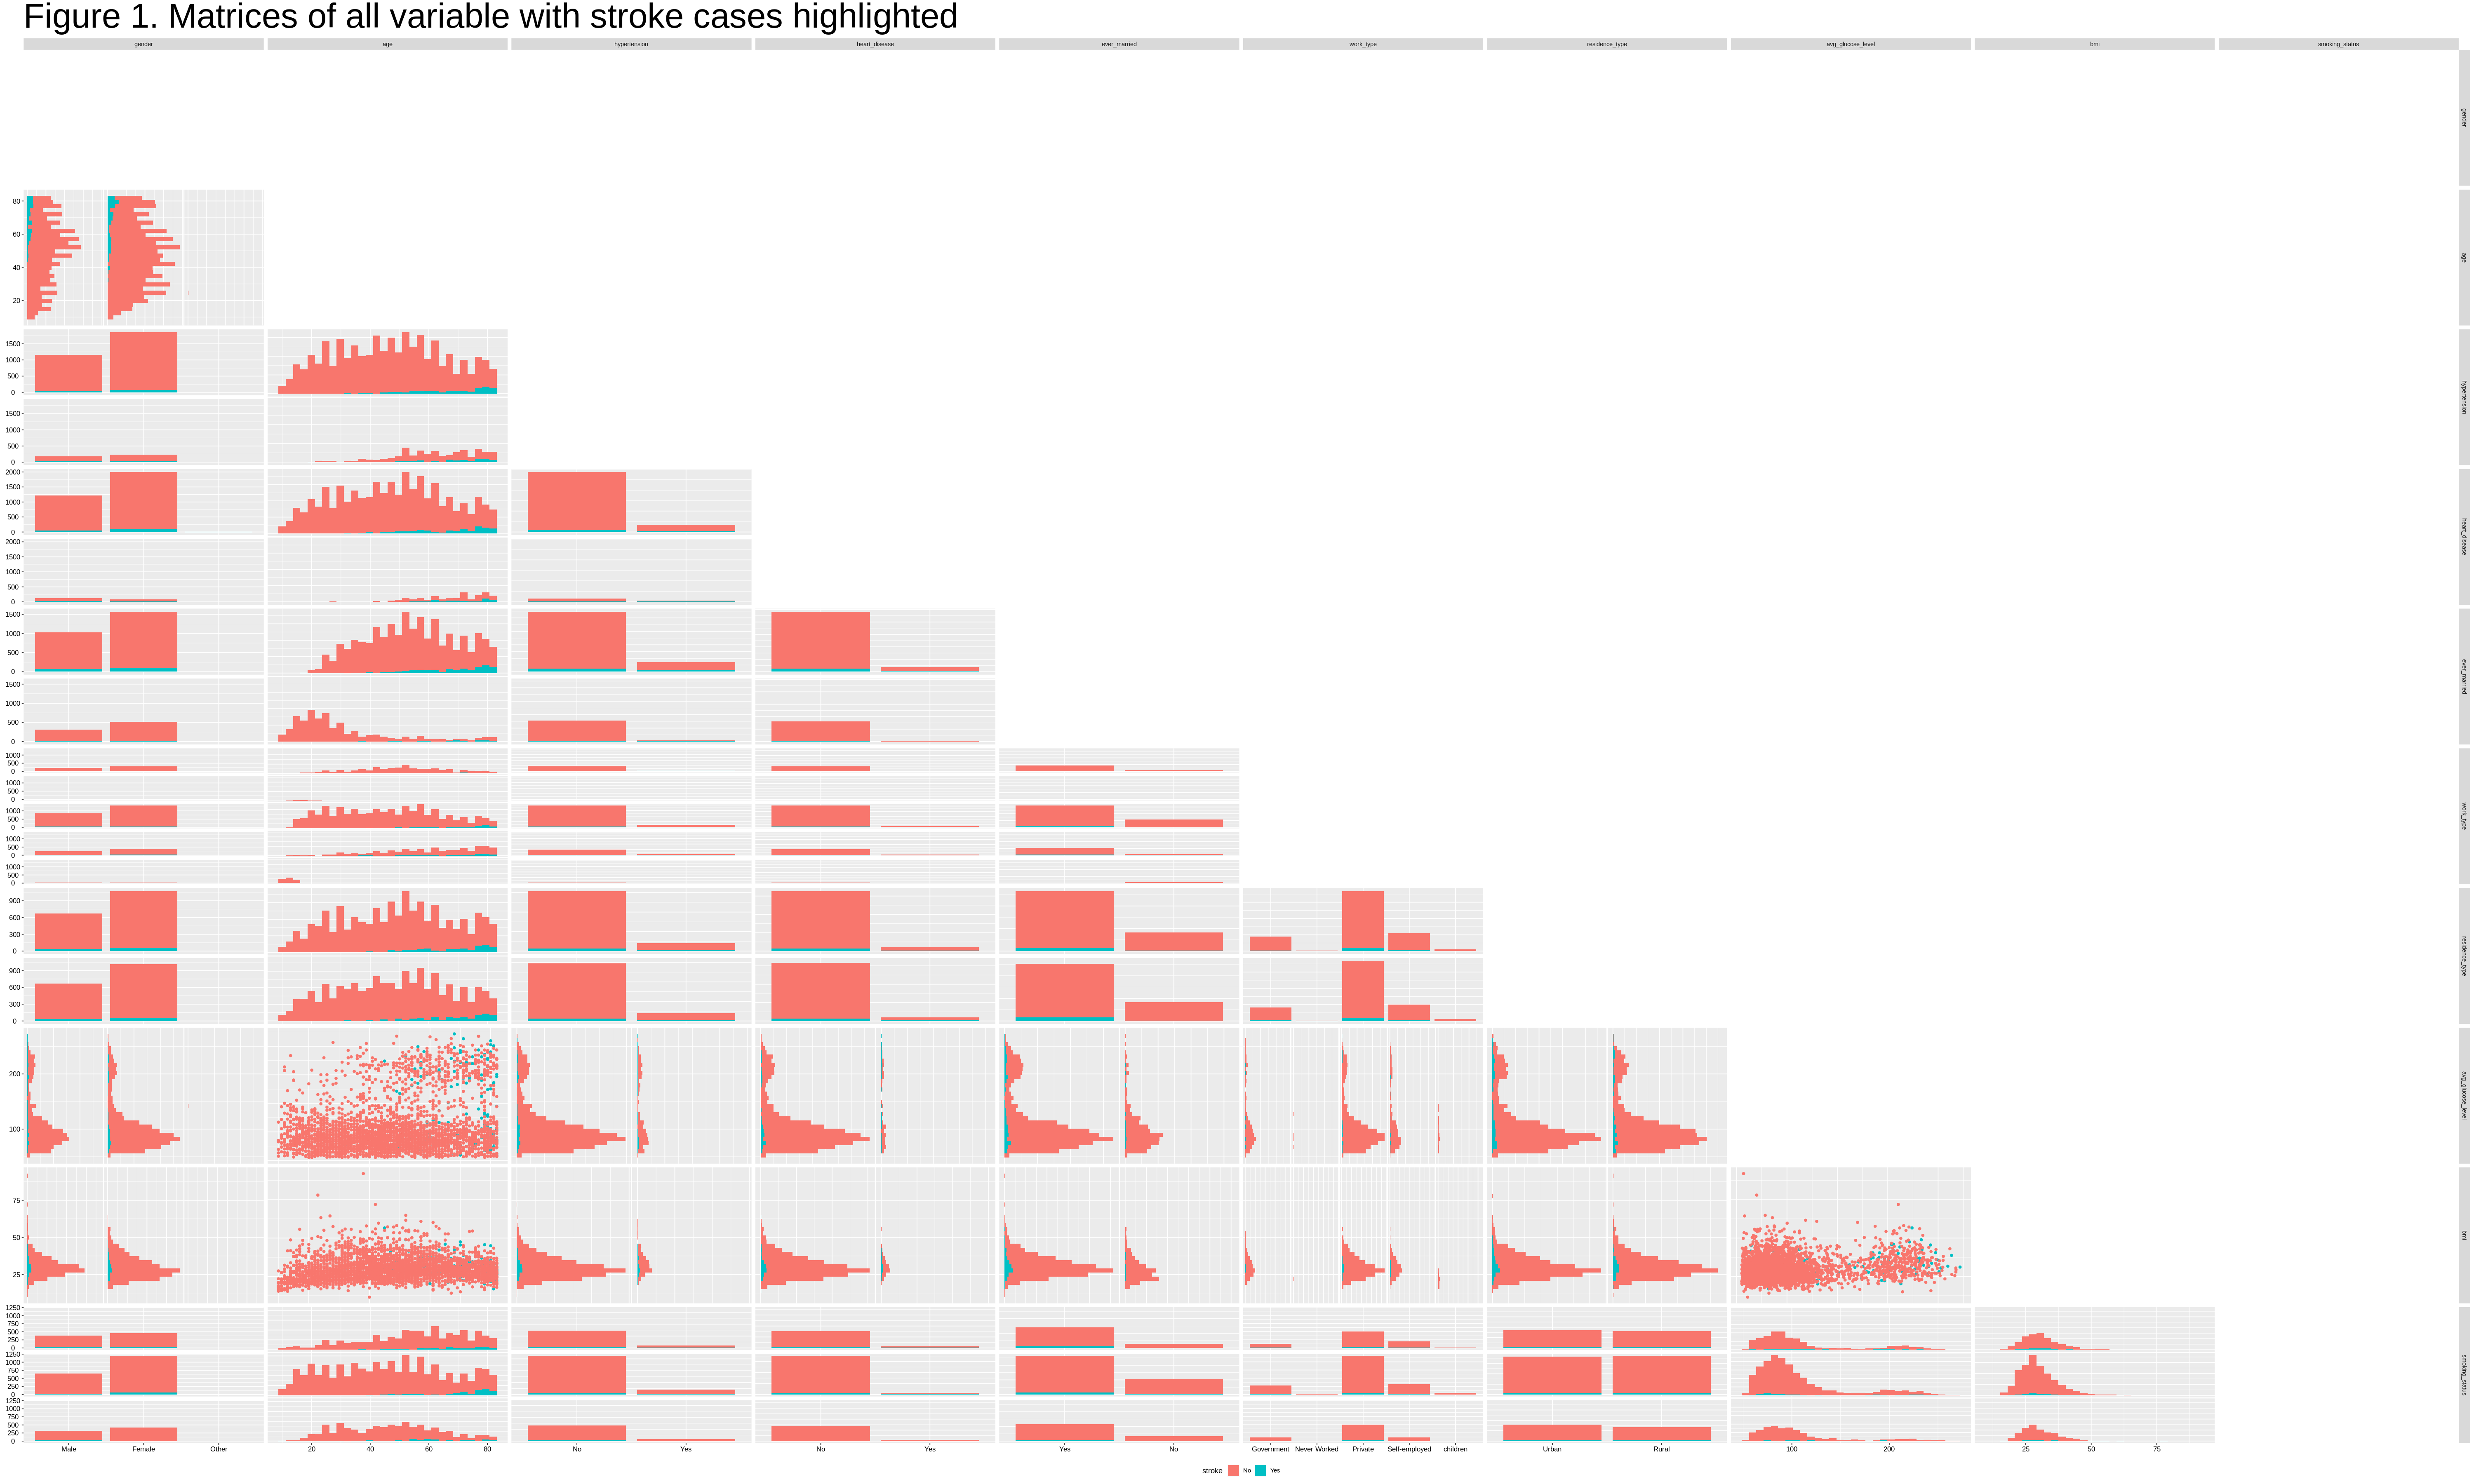

In [143]:
options(repr.plot.width = 50, repr.plot.height = 30) 

plot_pairs <- stroke |>   
  ggpairs(legend=11,
          columns=2:11,
          mapping = ggplot2::aes(color = stroke),
          upper="blank",
          diag = NULL)+


          labs(color="Verification")+

          ggtitle("Figure 1. Matrices of all variable with stroke cases highlighted") +

          theme(plot.title = element_text(hjust = 0, size = 50),
                axis.text.x = element_text(hjust = .5, color = "black", size=10),
                axis.text.y = element_text(hjust = .5, color = "black",size=10),
                legend.position = "bottom")
    
suppressMessages(suppressWarnings(print(plot_pairs)))

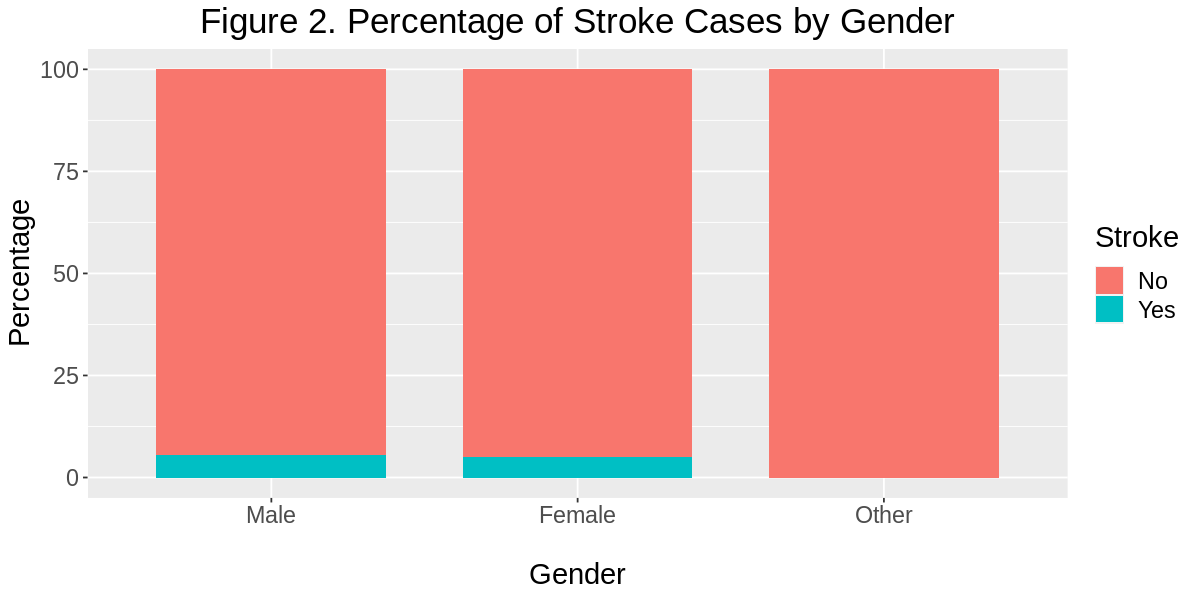

In [144]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_gender <- stroke |>
  count(gender, stroke) |>
  group_by(gender) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = gender, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nGender", y = "Percentage", fill = "Stroke", title = "Figure 2. Percentage of Stroke Cases by Gender") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_gender

There was no difference between males and females in terms of the number of stroke cases.

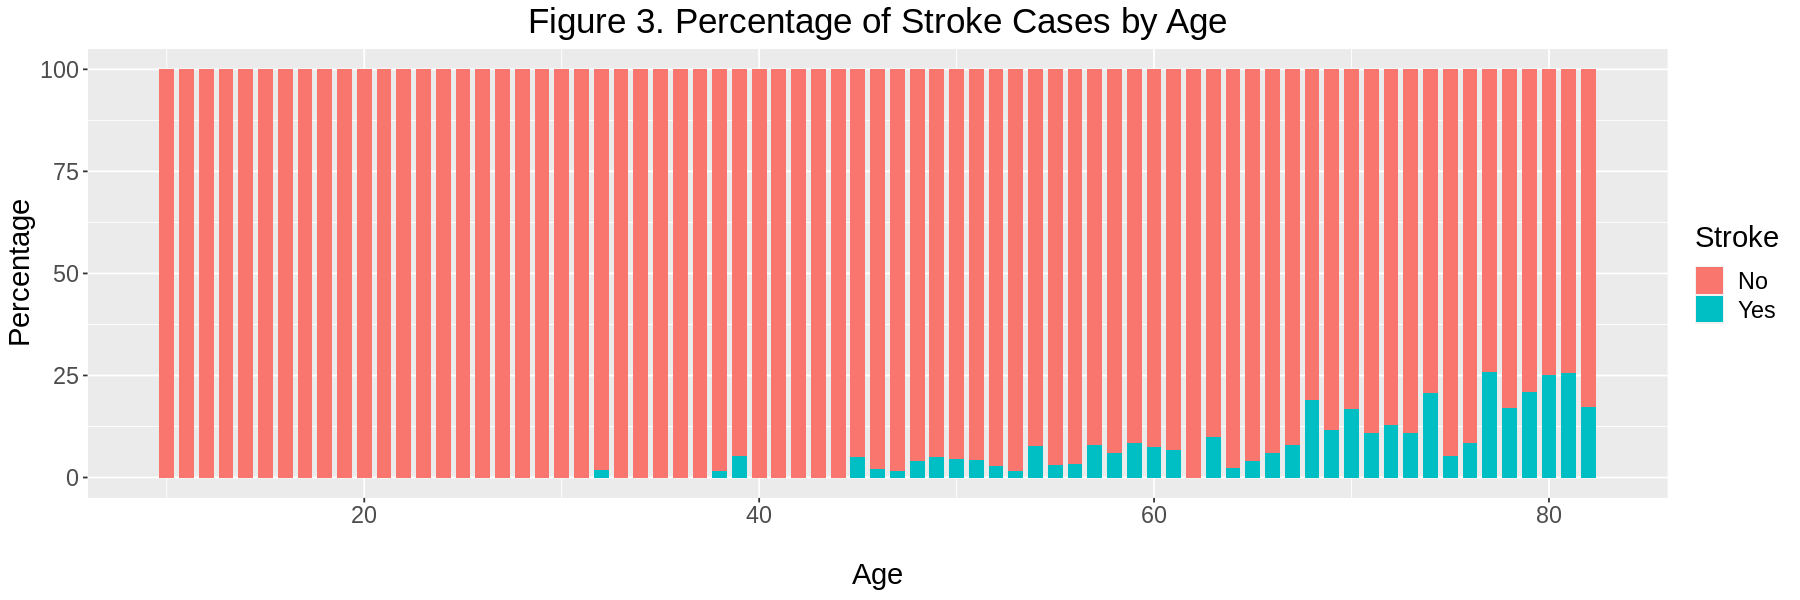

In [145]:
options(repr.plot.width = 15, repr.plot.height = 5) 

stroke_age <- stroke |>
  count(age, stroke) |>
  group_by(age) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = age, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nAge", y = "Percentage", fill = "Stroke", title = "Figure 3. Percentage of Stroke Cases by Age") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
suppressWarnings(print(stroke_age))

With regards to age, quite significantly less than 12.5% of the patients under 40 years of age had suffered a stroke. Between the ages of 40 and 50, the number of cases rose to just under 12.5%. Between the ages of 50 and 60, we start to see those cases rise to greater than 12.5% but stay under 25%. However, once participants past their early 60s, we see a somewhat substantial increase in the number of cases, up to, and in a few age groups, greater than 25%. The data suggests that those who are above the age of 60 are roughly twice as likely to suffer a stroke than those who are in their mid to late 40s.

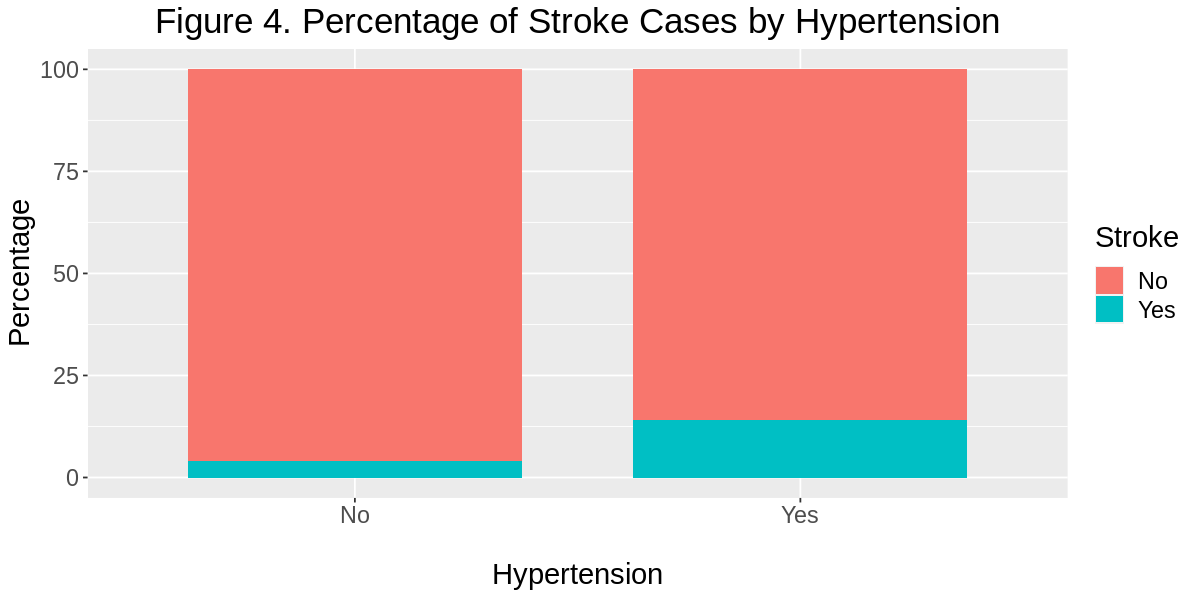

In [146]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_hypertension <- stroke |>
  count(hypertension, stroke) |>
  group_by(hypertension) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = hypertension, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nHypertension", y = "Percentage", fill = "Stroke", title = "Figure 4. Percentage of Stroke Cases by Hypertension") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_hypertension

Those who have suffered hypertension are roughly twice as likely to have a stroke, which is around 12.5% of the cases.

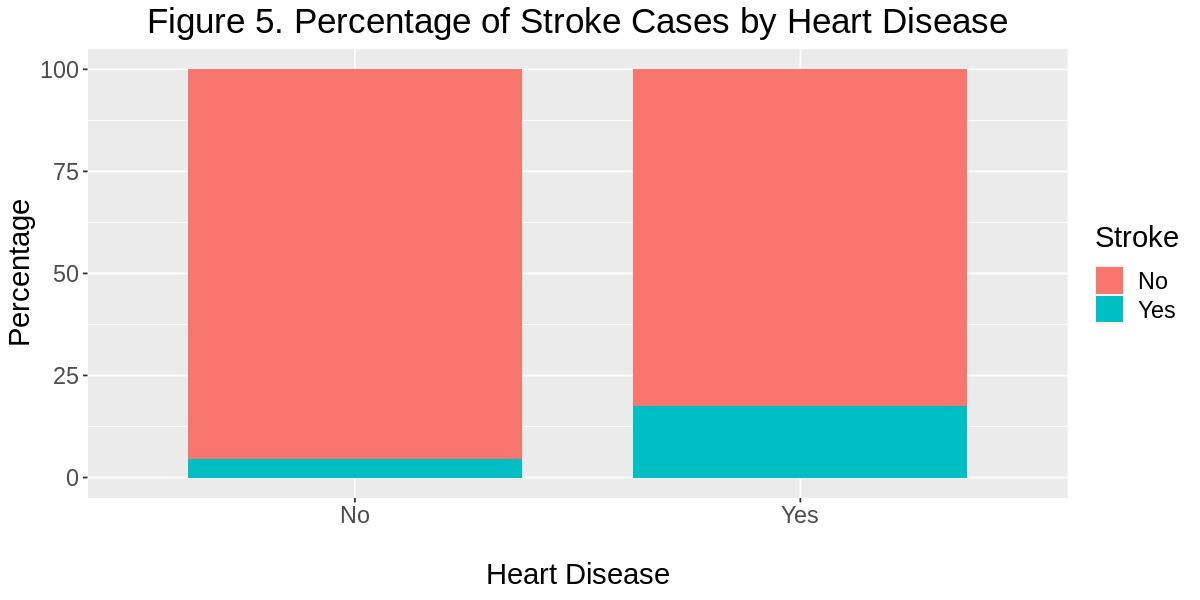

In [147]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_heart_disease <- stroke %>%
  count(heart_disease, stroke) %>%
  group_by(heart_disease) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = heart_disease, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nHeart Disease", y = "Percentage", fill = "Stroke", title = "Figure 5. Percentage of Stroke Cases by Heart Disease") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_heart_disease

Those who have suffered heart disease are roughly twice as likely to have a stroke, which is around 20-25% of the cases.

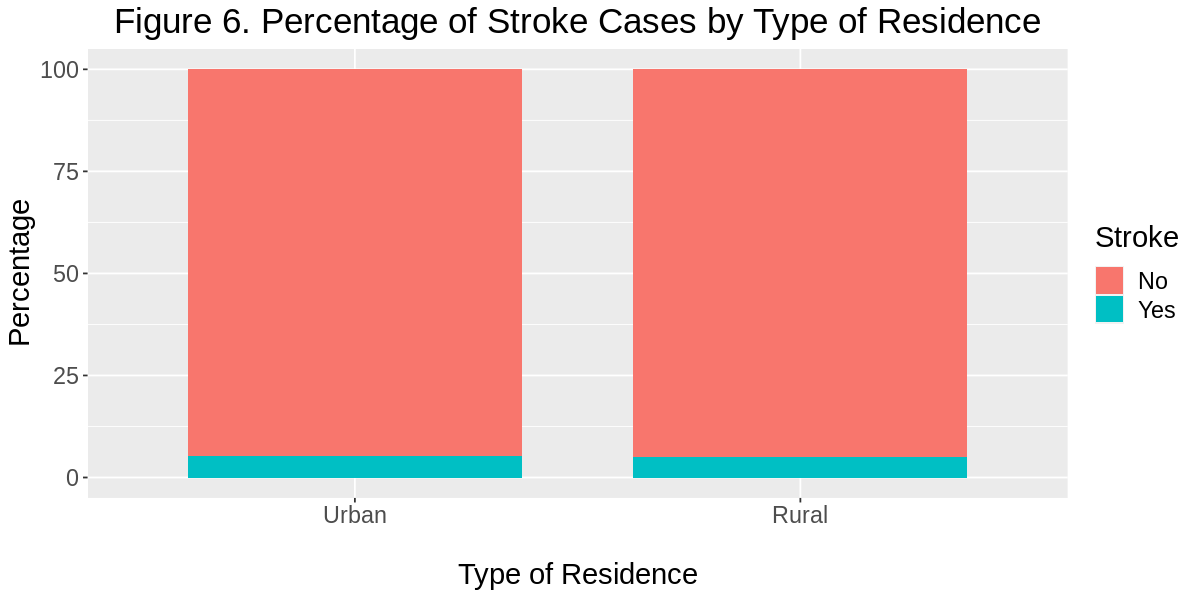

In [148]:
options(repr.plot.width = 10, repr.plot.height = 5) 

stroke_residence <- stroke %>%
  count(residence_type, stroke) %>%
  group_by(residence_type) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = residence_type, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nType of Residence", y = "Percentage", fill = "Stroke", title = "Figure 6. Percentage of Stroke Cases by Type of Residence") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_residence

There is no difference between those who live in urban areas and those who live in more rural areas and their likelihood of getting a stroke.

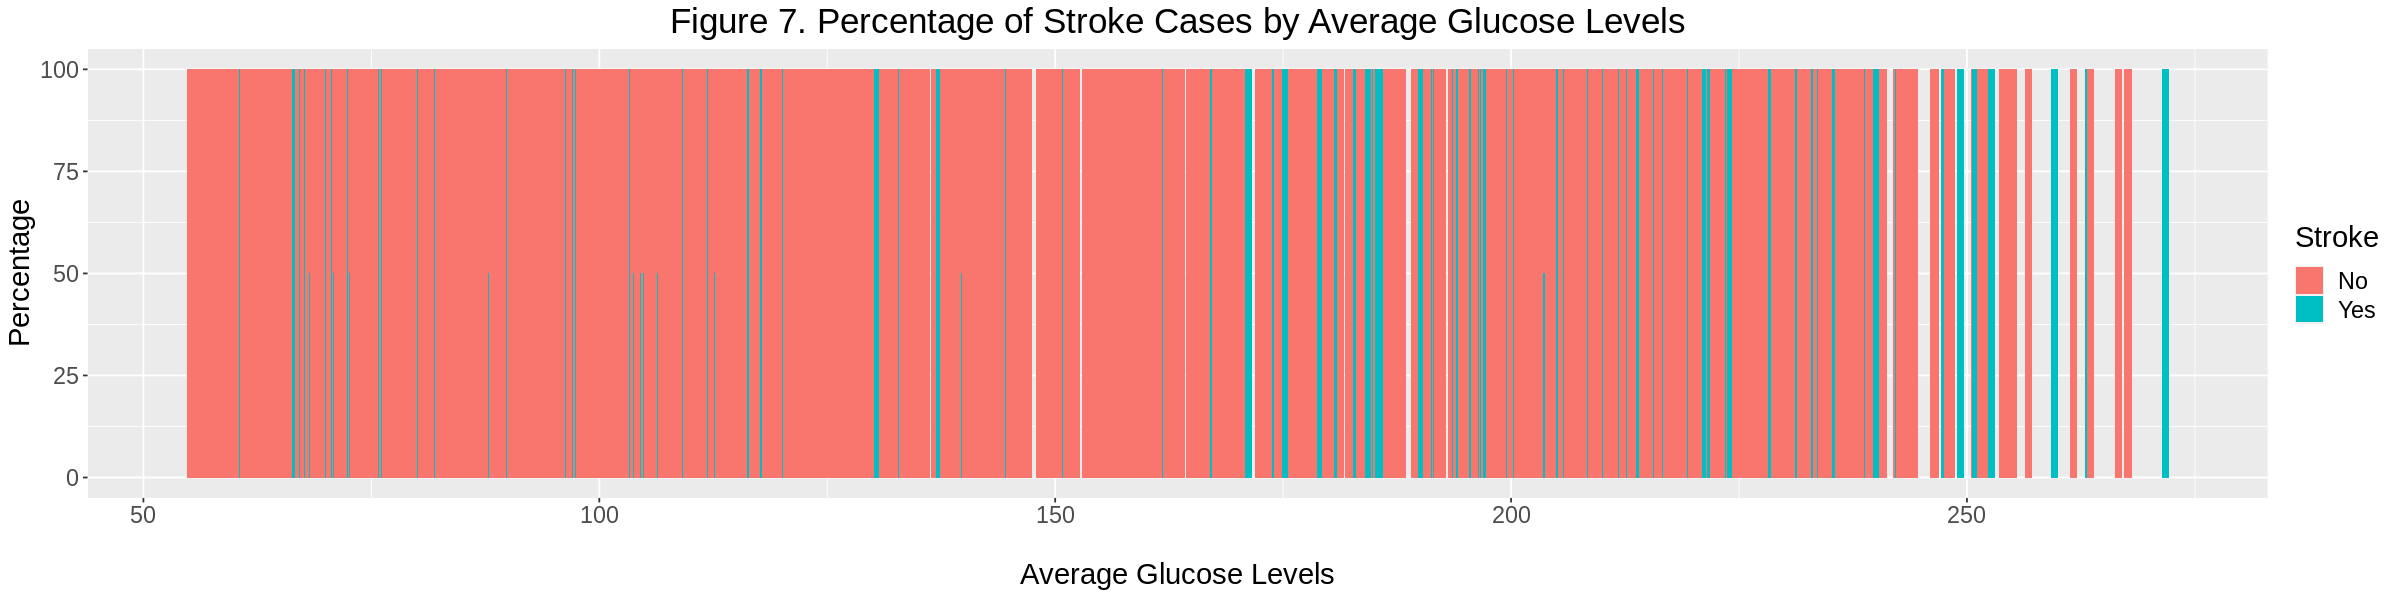

In [149]:
options(repr.plot.width = 20, repr.plot.height = 5) 

stroke_avg_glucose_level <- stroke %>%
  count(avg_glucose_level, stroke) %>%
  group_by(avg_glucose_level) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = avg_glucose_level, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .75) +
  labs(x = "\nAverage Glucose Levels", y = "Percentage", fill = "Stroke", title = "Figure 7. Percentage of Stroke Cases by Average Glucose Levels") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
suppressWarnings(print(stroke_avg_glucose_level))

There is an association between stroke cases and average glucose levels, as the higher the average glucose level, the greater the frequency of a participant having had a stroke.

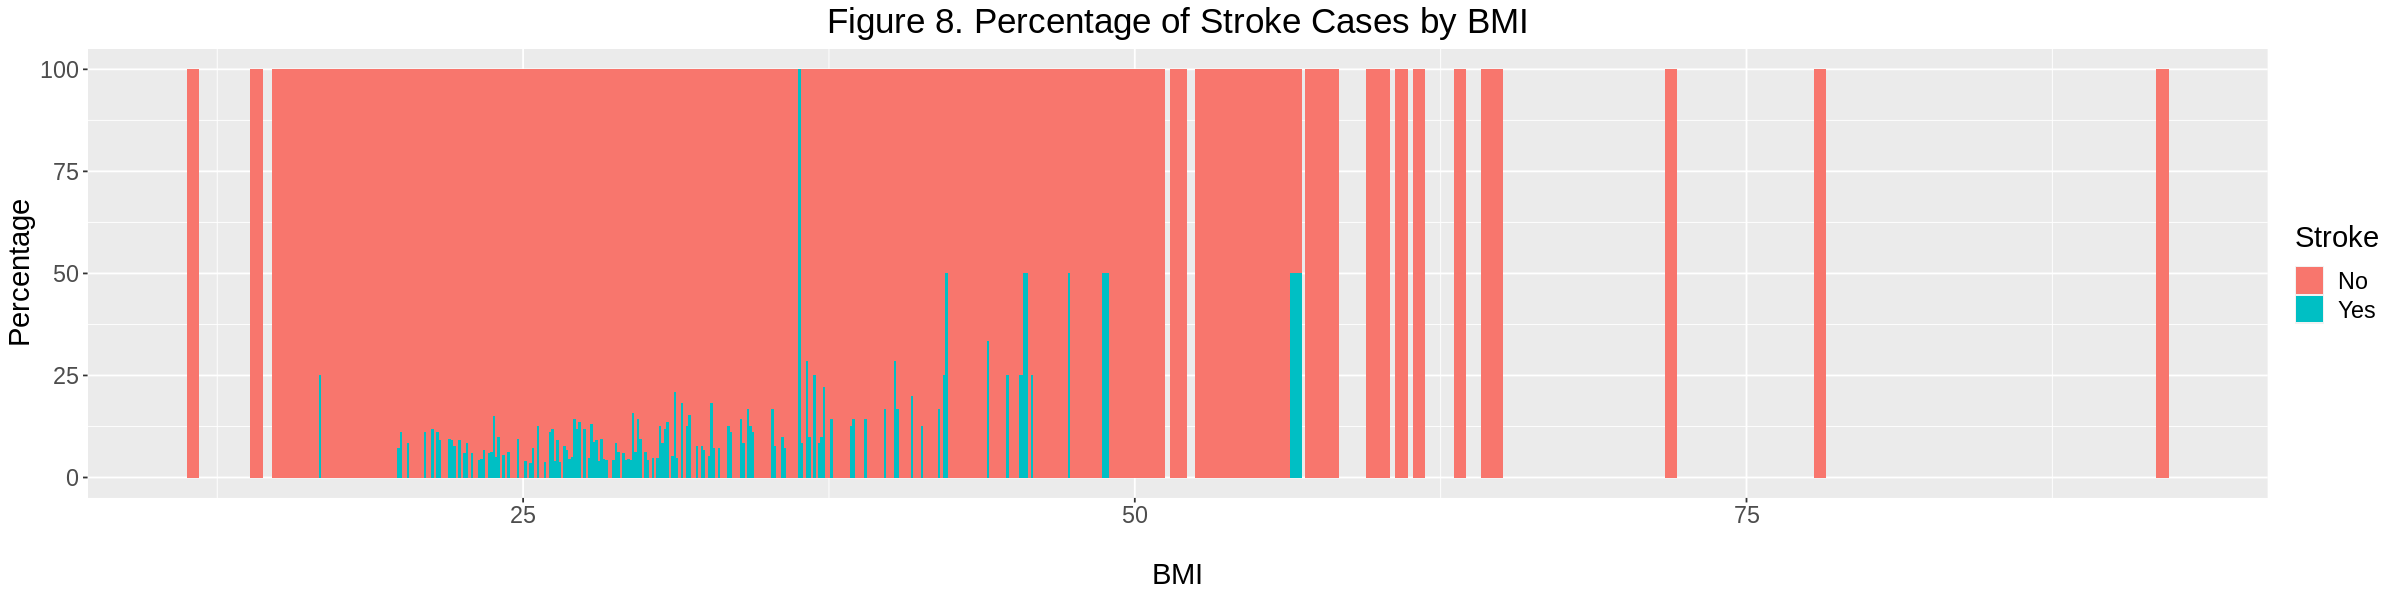

In [150]:
options(repr.plot.width = 20, repr.plot.height = 5) 

stroke_bmi <- stroke %>%
  count(bmi, stroke) %>%
  group_by(bmi) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = bmi, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity", width = .5) +
  labs(x = "\nBMI", y = "Percentage", fill = "Stroke", title = "Figure 8. Percentage of Stroke Cases by BMI") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
suppressWarnings(print(stroke_bmi))

There is a link between BMI and strokes. According to our analysis, we start to see a positive linear relationship starting from a BMI of 20 to 40, and a percentage of stroke cases ranging from roughly 5% to 25%. Once we reach a BMI of 50 and above, we see numerous occasions where stroke cases rise to 50% or greater.

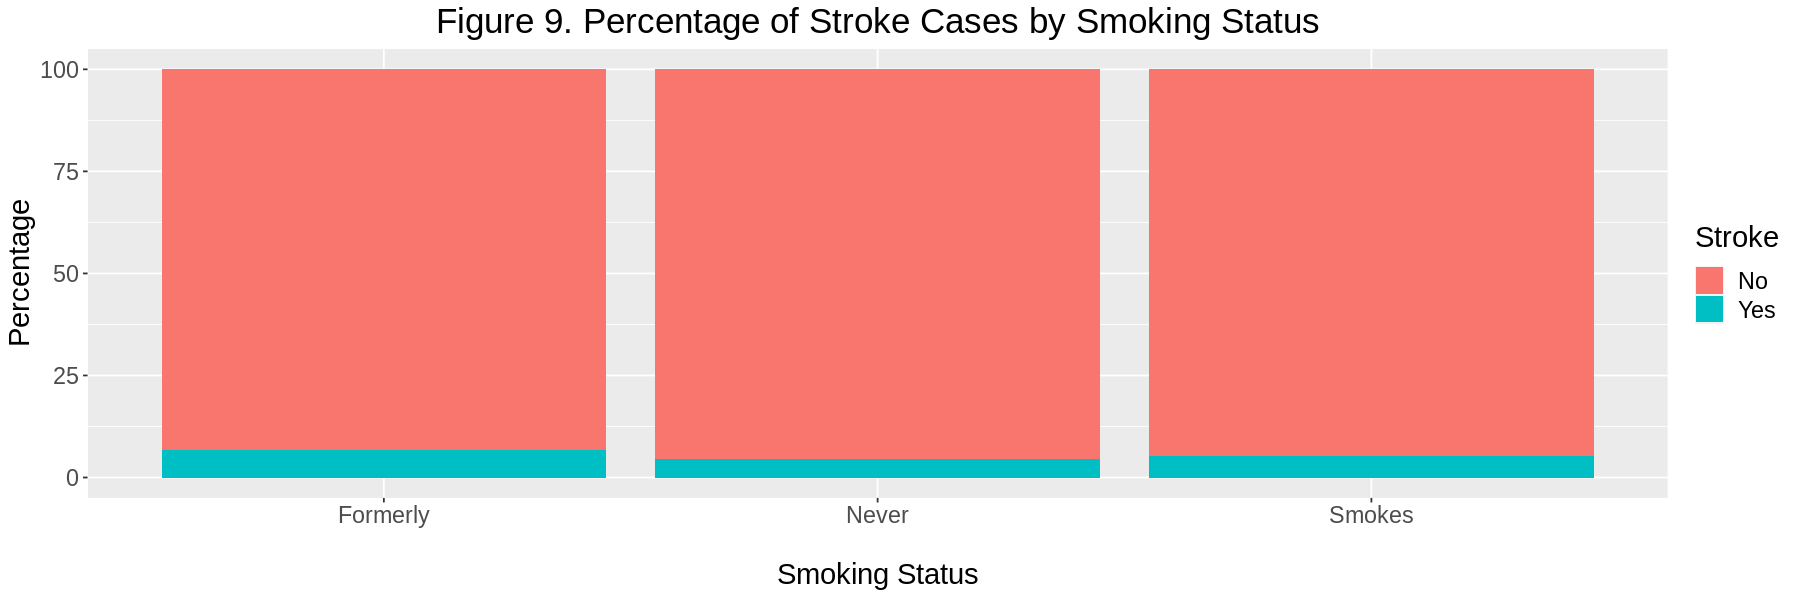

In [151]:
options(repr.plot.width = 15, repr.plot.height = 5) 

stroke_smoking_status <- stroke %>%
  count(smoking_status, stroke) %>%
  group_by(smoking_status) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ggplot(aes(x = smoking_status, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  labs(x = "\nSmoking Status", y = "Percentage", fill = "Stroke", title = "Figure 9. Percentage of Stroke Cases by Smoking Status") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_smoking_status

The percentage of cases are quite similar between the three groups. However, those who have formerly smoked have a slightly higher risk of stroke than those who smoke. This may be due to current smokers being younger or having less overall damage than those who are former smokers. Potentially, those who are former smokers may have been heavy smokers which could explain why they quit smoking compared to those who currently smoke. Interestingly, those who have never smoked have the same likelihood of suffering a stroke as those who currently smoke. This means that other lifestyle factors likely play a significant role in the risk of getting a stroke.

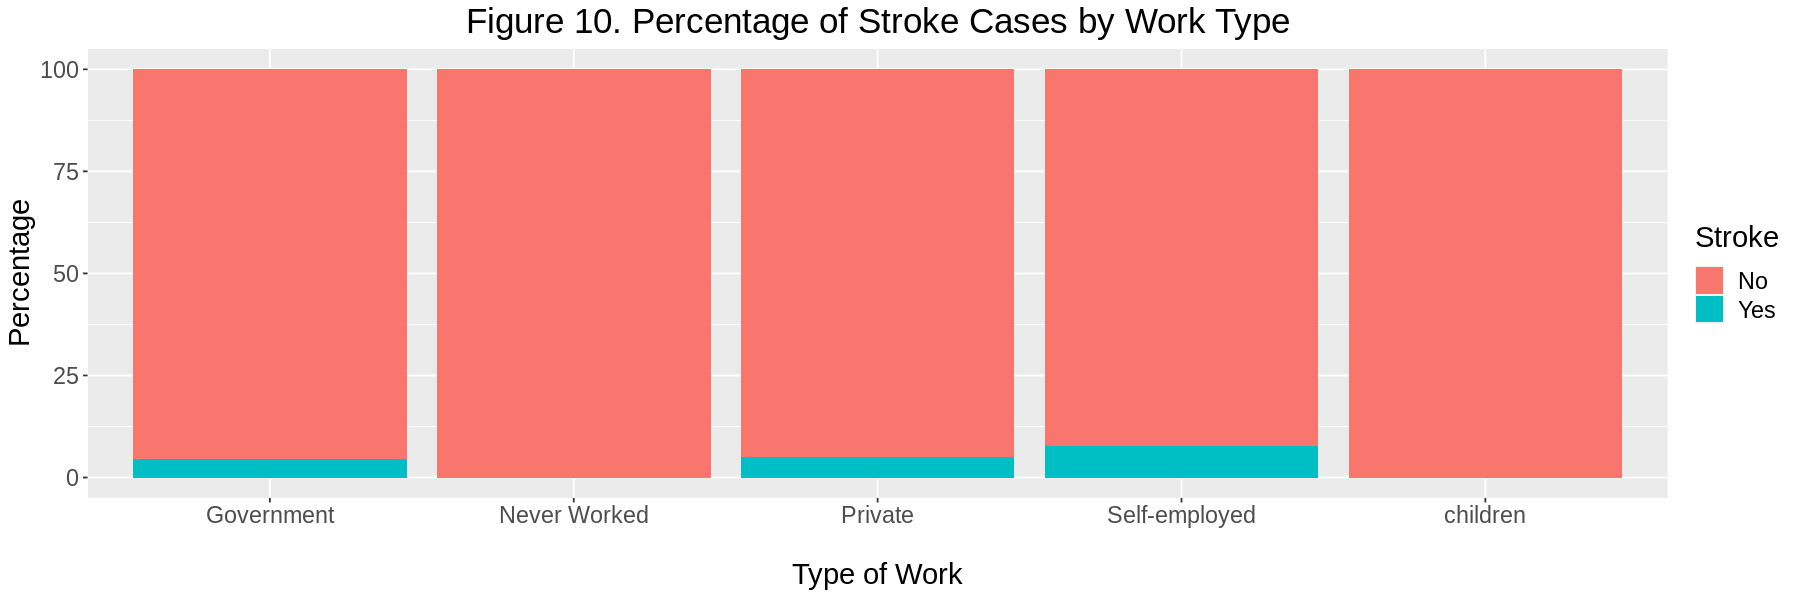

In [152]:
stroke_worktype_plot <- stroke |>
  count(work_type, stroke) |>
  group_by(work_type) |>
  mutate(percentage = n / sum(n) * 100) |>
  ggplot(aes(x = work_type, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  labs(x = "\nType of Work", y = "Percentage", fill = "Stroke", title = "Figure 10. Percentage of Stroke Cases by Work Type") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))
stroke_worktype_plot

Those who are self-employed are roughly twice as likely to suffer a stroke than those who work in government or in the private sector, at around 20% of cases. Potentially, this is due to self employed participants being in more incidents where their blood pressure is high because of the uncertainties that are associated with being in that work type.

## Further Analysis

To further explore the relationships between stroke and various clinical variables, we conducted an analysis focusing on two key variables in relations to strokes. By examining their associations with stroke, we aimed to uncover potential interrelations and gain deeper insights into their significance.

`summarise()` has grouped output by 'gender', 'age'. You can override using the
`.groups` argument.


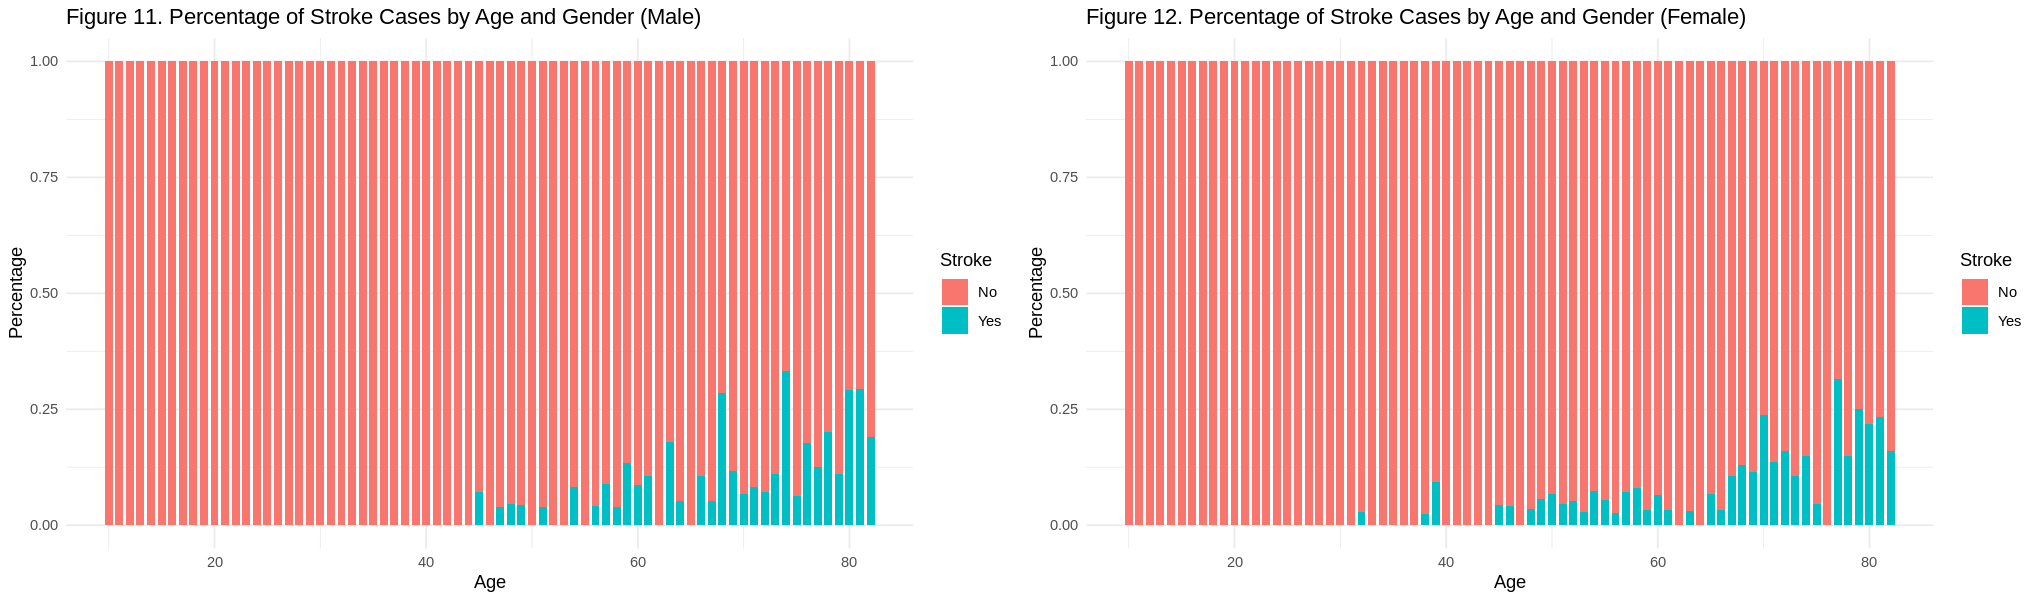

In [153]:
options(repr.plot.height = 5, repr.plot.width = 17)

percentage <- stroke %>%
  group_by(gender, age, stroke) %>%
  summarize(count = n()) %>%
  ungroup() %>%
  group_by(gender, age) %>%
  mutate(stroke_percentage = count / sum(count))

# Plot for males
male_data <- percentage %>%
  filter(gender == "Male")

male_plot <- ggplot(male_data, aes(x = age, y = stroke_percentage, fill = stroke)) +
  geom_bar(stat = "identity", position = "stack", width = .75) +
  labs(x = "Age", y = "Percentage", fill = "Stroke", title = "Figure 11. Percentage of Stroke Cases by Age and Gender (Male)") +
  theme_minimal()

# Plot for females
female_data <- percentage %>%
  filter(gender == "Female")

female_plot <- ggplot(female_data, aes(x = age, y = stroke_percentage, fill = stroke)) +
  geom_bar(stat = "identity", position = "stack", width = .75) +
  labs(x = "Age", y = "Percentage", fill = "Stroke", title = "Figure 12. Percentage of Stroke Cases by Age and Gender (Female)") +
  theme_minimal()

# Combine the plots side by side
grid.arrange(male_plot, female_plot, nrow = 1)

While in our initial analysis, Gender was found to not be a good predictor of strokes, we decided to see if there was a correlation between Age, Gender, and Strokes. It appears that the risk of stroke is slightly greater in older men than older women; however, age seems to be the more dominant feature. We decided to still consider gender in our model as we were interested in this difference as there is a chance some participants in the female population were pregnant, making blood more likely clot which could cause a stroke.

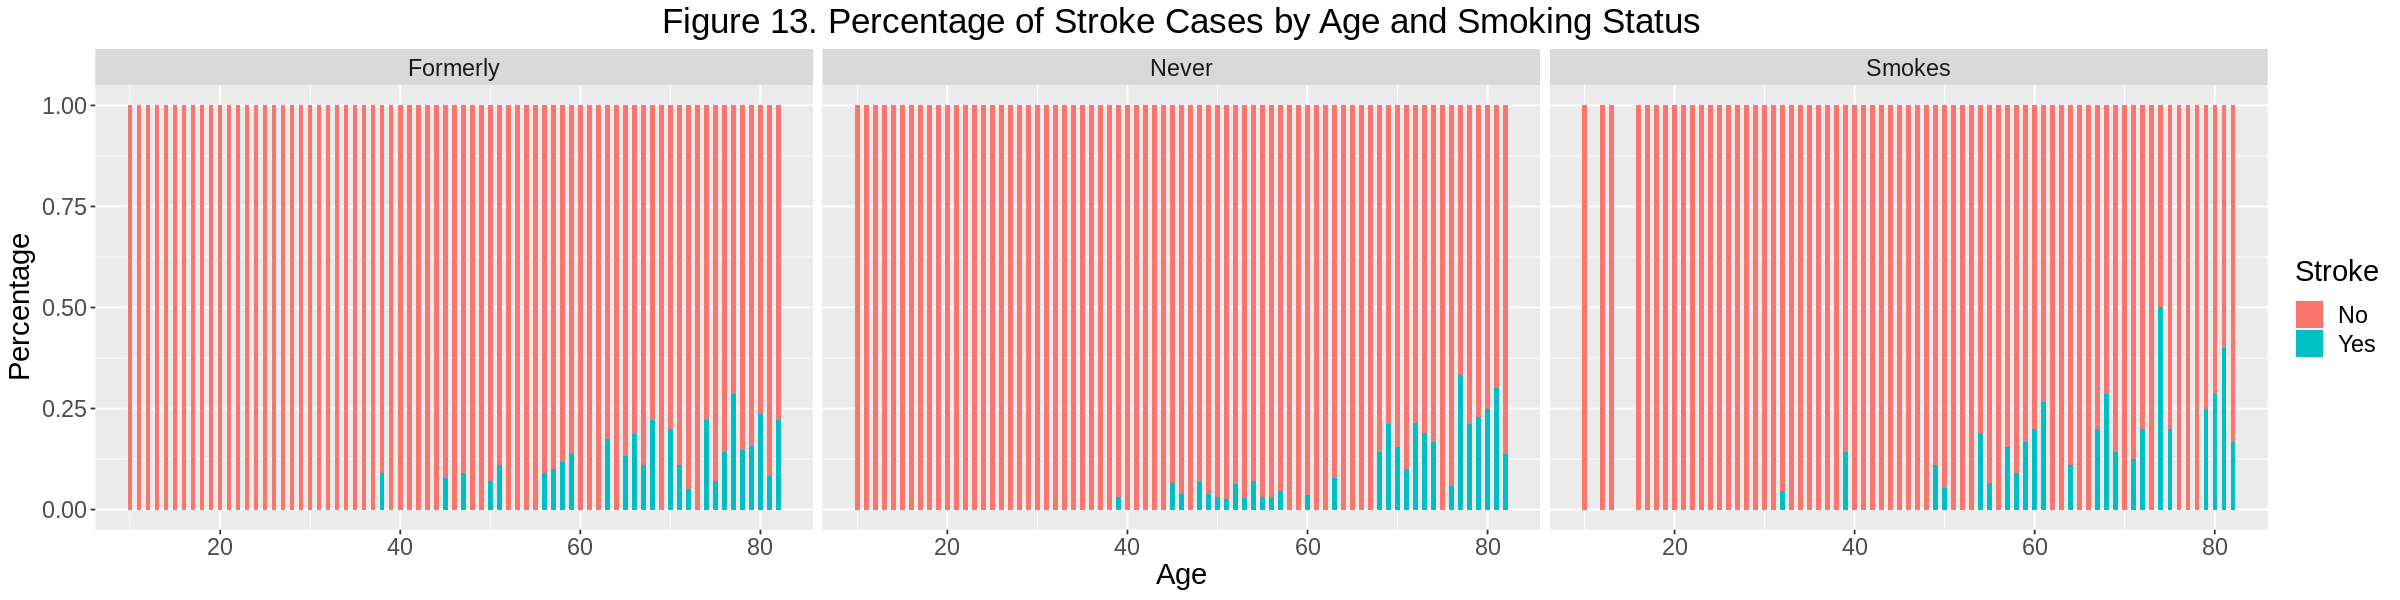

In [154]:
options(repr.plot.width = 20, repr.plot.height = 5) 

stroke_age_smoking <- stroke %>%
  ggplot(aes(x = age, fill = stroke)) +
  geom_bar(aes(y = ..count.. / sum(..count..)), position = "fill", width = .5) +
  facet_wrap(~ smoking_status) +
  labs(x = "Age", y = "Percentage", fill = "Stroke", title = "Figure 13. Percentage of Stroke Cases by Age and Smoking Status") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))

suppressWarnings(print(stroke_age_smoking))

All smoking groups had roughly equal numbers of stroke cases with the common ground being that with age, there was an average increase in percentage of strokes. The main difference is that the peak percentage was highest in the group that currently “smokes” at around 50%. The “never” smoking and “formerly” smoking groups peaked at percentages between 40% to 50%. Interestingly, former smokers had higher percentages than those who never smoked. Both of those groups had lower percentages in comparison to current smokers, especially as age increases. This suggests a relationship that has been observed in the past, where stopping smoking for 5 years reduced the risk of stroke comparable to that of a nonsmoker in most cases (Shah & Cole, 2010).

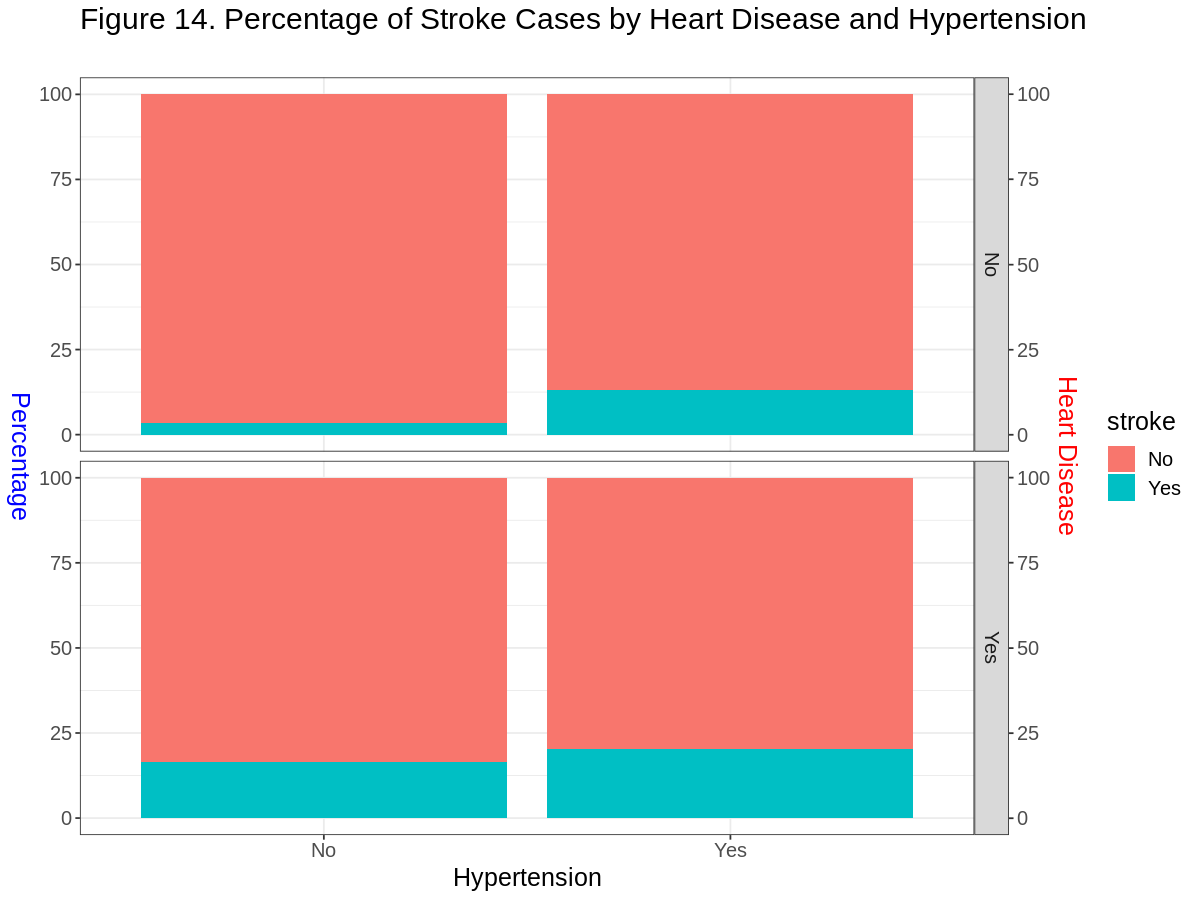

In [175]:
options(repr.plot.width = 10, repr.plot.height = 7.5) 

heartdisease_hypertension <- stroke %>%
  count(hypertension, stroke, heart_disease) %>%
  group_by(hypertension,heart_disease) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ungroup()

ggplot(heartdisease_hypertension, aes(x = hypertension, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  labs(x = "Hypertension", y = "", title = "Figure 14. Percentage of Stroke Cases by Heart Disease and Hypertension\n") +
  facet_grid(heart_disease ~ .) +
  theme_bw() +
  theme(
    axis.title.y.right = element_text(color = "red", size = 15, angle = -90, vjust = 0.5),
    axis.title.y.left = element_text(color = "blue", size = 15, angle = -90, vjust = 0.5)
  ) +
  theme(text = element_text(size = 15),
    plot.title = element_text(hjust = 0))+
  scale_y_continuous(
    name = "Percentage",
    sec.axis = sec_axis(~ ., name = "Heart Disease")
  )


In general, individuals without hypertension and heart disease have the lowest likelihood of having had a stroke, with a prevalence of less than 5%. However, those with both hypertension and heart disease exhibit the highest percentage, around 18%, of stroke cases. Participants with only heart disease have a lower likelihood, less than 18%, while those with only hypertension have an approximate 13% likelihood of having had a stroke.

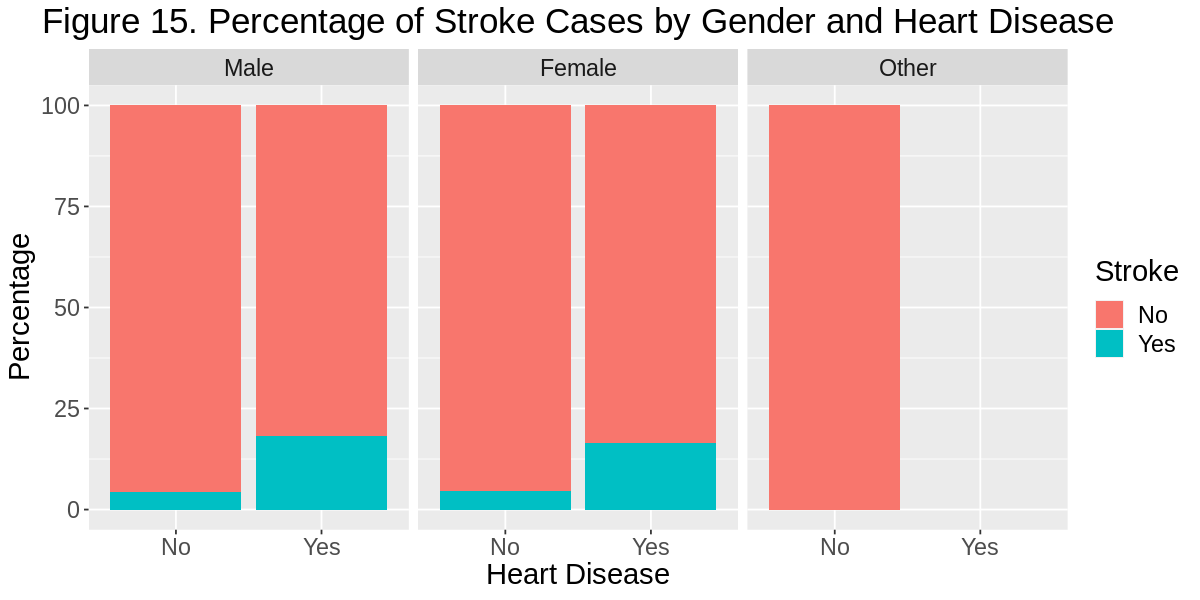

In [156]:
options(repr.plot.width = 10, repr.plot.height = 5) 

heartdisease_gender <- stroke %>%
  count(gender, heart_disease, stroke) %>%
  group_by(gender, heart_disease) %>%
  mutate(percentage = n / sum(n) * 100)

# Create the plot
stroke_gender_plot <- heartdisease_gender %>%
  ggplot(aes(x = heart_disease, y = percentage, fill = stroke)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ gender) +
  labs(x = "Heart Disease", y = "Percentage", fill = "Stroke", title = "Figure 15. Percentage of Stroke Cases by Gender and Heart Disease") +
  theme(text = element_text(size = 17.5), plot.title = element_text(hjust = 0.5))

# Display the plot
print(stroke_gender_plot)

While there isn't a strong association between heart disease and gender, both male and female participants with heart disease have a notably higher likelihood of having had a stroke compared to those without a heart condition.

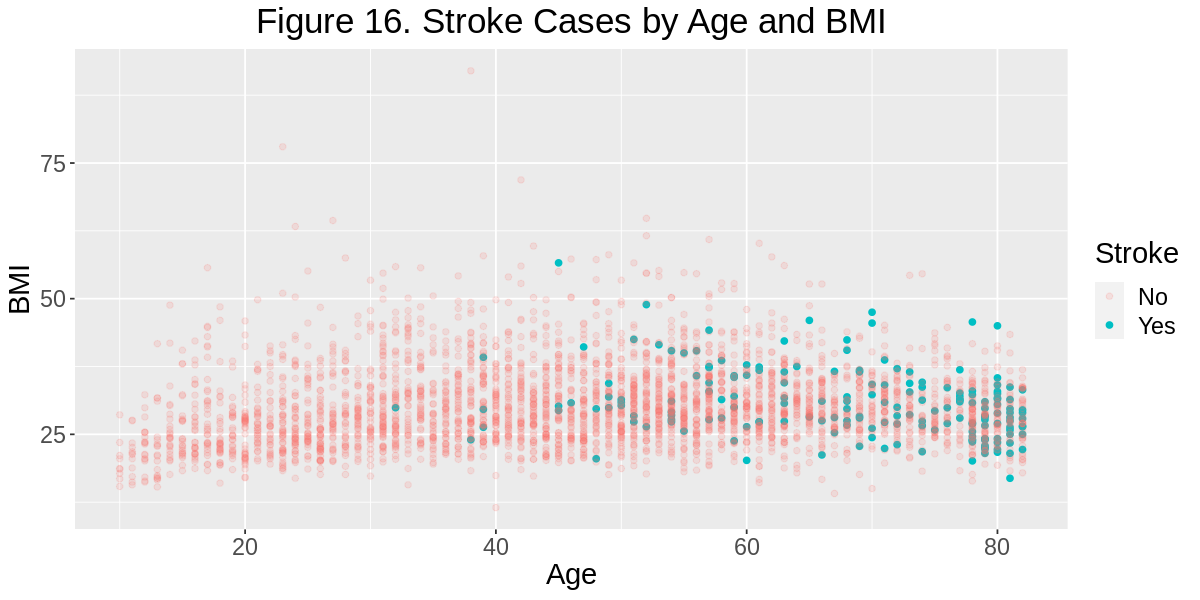

In [157]:
age_bmi <- stroke %>%
  ggplot(aes(x = age, y = bmi, colour = stroke)) +
  geom_point() +
  labs(x = "Age", y = "BMI", color = "Stroke", title = "Figure 16. Stroke Cases by Age and BMI") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5))+
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

age_bmi

Age seems to be the main predictor of stroke when BMI is roughly under 25. However, this is not for a majority of the cases. Most cases where participants have suffered a stroke, they tend to be above 50 years old and have a BMI of greater than 25.

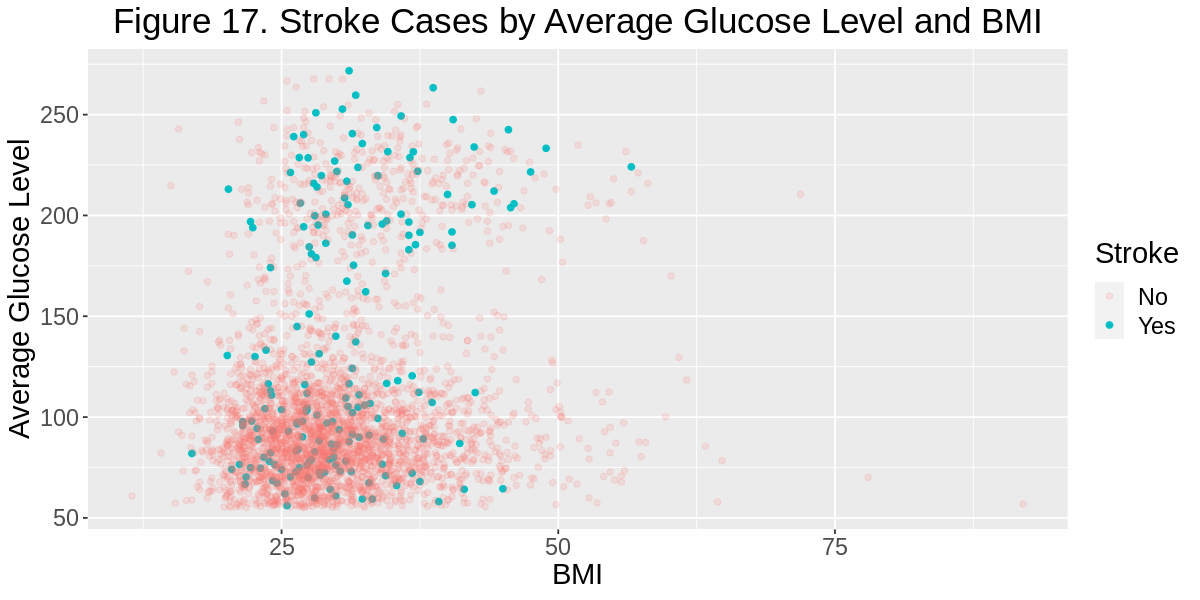

In [158]:
glucose_bmi <- stroke %>%
  ggplot(aes(x = bmi, y = avg_glucose_level, colour = stroke)) +
  geom_point() +
  labs(x = "BMI", y = "Average Glucose Level", color = "Stroke", title = "Figure 17. Stroke Cases by Average Glucose Level and BMI") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

glucose_bmi

Our analysis suggests that participants with a BMI of 25 or higher make up a majority  of the instances of strokes regardless of average glucose levels. The majority of participants who did not suffer a stroke had average glucose levels  of under 150. This tells us that BMI is a stronger predictor of whether someone had a stroke, but maintaining glucose levels at under 150 and BMI under 25 may reduce the risks of stroke. 

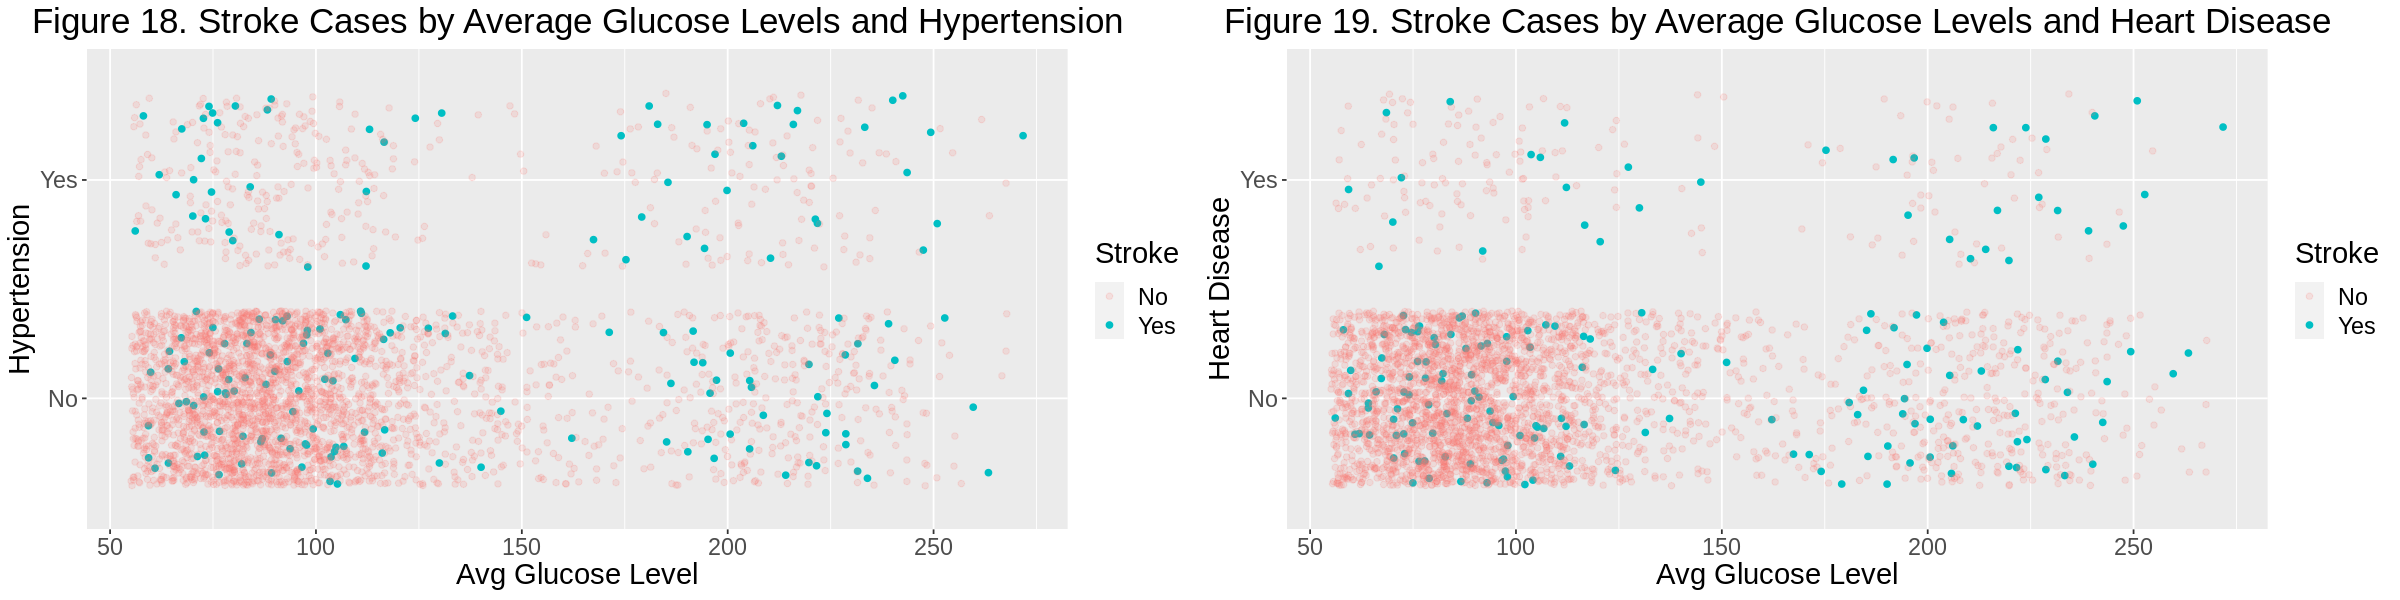

In [159]:
glucose_hypertension <- stroke %>%
  ggplot(aes(x = avg_glucose_level, y = hypertension, colour = stroke)) +
  geom_jitter() +
  labs(x = "Avg Glucose Level", y = "Hypertension", color = "Stroke", title = "Figure 18. Stroke Cases by Average Glucose Levels and Hypertension") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

glucose_heartdisease <- stroke %>%
  ggplot(aes(x = avg_glucose_level, y = heart_disease, colour = stroke)) +
  geom_jitter() +
  labs(x = "Avg Glucose Level", y = "Heart Disease", color = "Stroke", title = "Figure 19. Stroke Cases by Average Glucose Levels and Heart Disease") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

options(repr.plot.width = 20, repr.plot.height = 5) 

grid.arrange(glucose_hypertension, glucose_heartdisease, ncol = 2)

##### Stroke Cases by Average Glucose Levels and Hypertension:
Most cases where the participant did not suffer a stroke are associated with not suffering hypertension and have an average glucose level of less than 125. Regardless of glucose levels, those who have had hypertension experience a similar percentage of stroke cases, suggesting that once someone has hypertension, glucose levels may not matter for stroke prediction. Those who have not had hypertension and have high average glucose levels (>175), had the highest percentage of strokes, but not by a significant margin compared to those who have hypertension, regardless of glucose levels.


##### Stroke Cases by Average Glucose Levels and Heart Disease:
Most cases where the participant did not suffer a stroke are associated with not suffering heart disease and have an average glucose level of less than 125. Regardless of glucose levels, those who have had heart disease experience a similar percentage of stroke cases, suggesting that once someone has heart disease, glucose levels may not matter for stroke prediction. However, we do have a lack of stroke cases in those who have an average glucose level around 150, who have suffered heart disease. Those who have not had heart disease and have high average glucose levels (>175), had the highest percentage of strokes. 


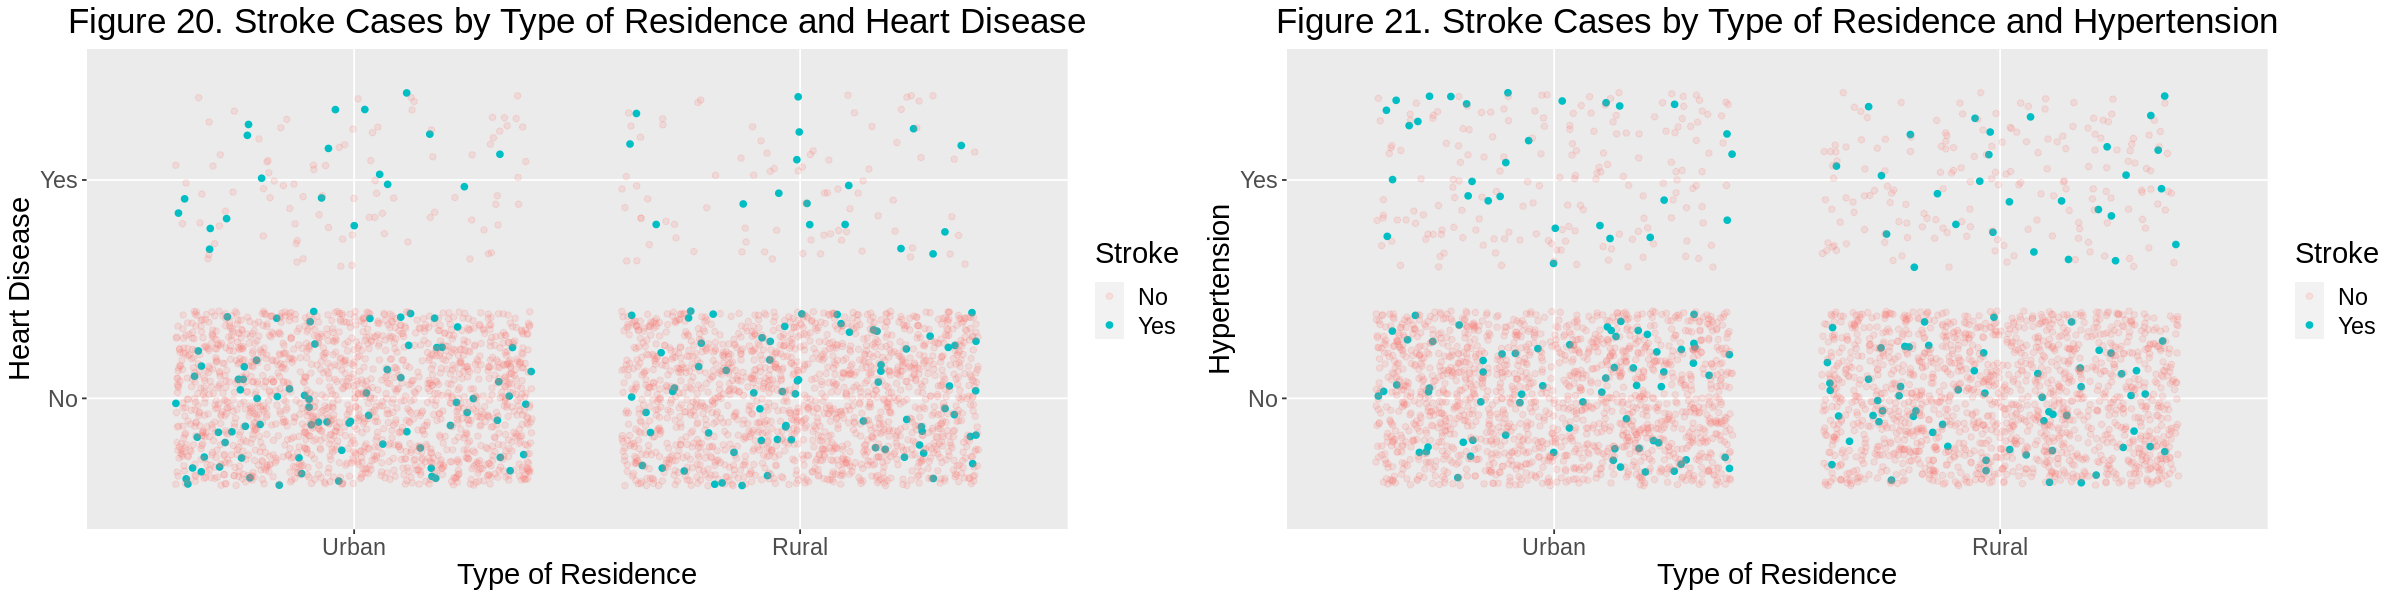

In [160]:
options(repr.plot.width = 10, repr.plot.height = 5) 

residence_heartdisease <- stroke %>%
  ggplot(aes(x = residence_type, y = heart_disease, colour = stroke)) +
  geom_jitter() +
  labs(x = "Type of Residence", y = "Heart Disease", color = "Stroke", title = "Figure 20. Stroke Cases by Type of Residence and Heart Disease") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

residence_hypertension <- stroke %>%
  ggplot(aes(x = residence_type, y = hypertension, colour = stroke)) +
  geom_jitter() +
  labs(x = "Type of Residence", y = "Hypertension", color = "Stroke", title = "Figure 21. Stroke Cases by Type of Residence and Hypertension") +
  theme(text = element_text(size = 17.5),
    plot.title = element_text(hjust = 0.5)) +
  scale_color_manual(values = alpha(c("No" = "#F8766D", "Yes" = "#00BFC4"), c(0.15, 1.0)))

options(repr.plot.width = 20, repr.plot.height = 5) 

grid.arrange(residence_heartdisease, residence_hypertension, ncol = 2)


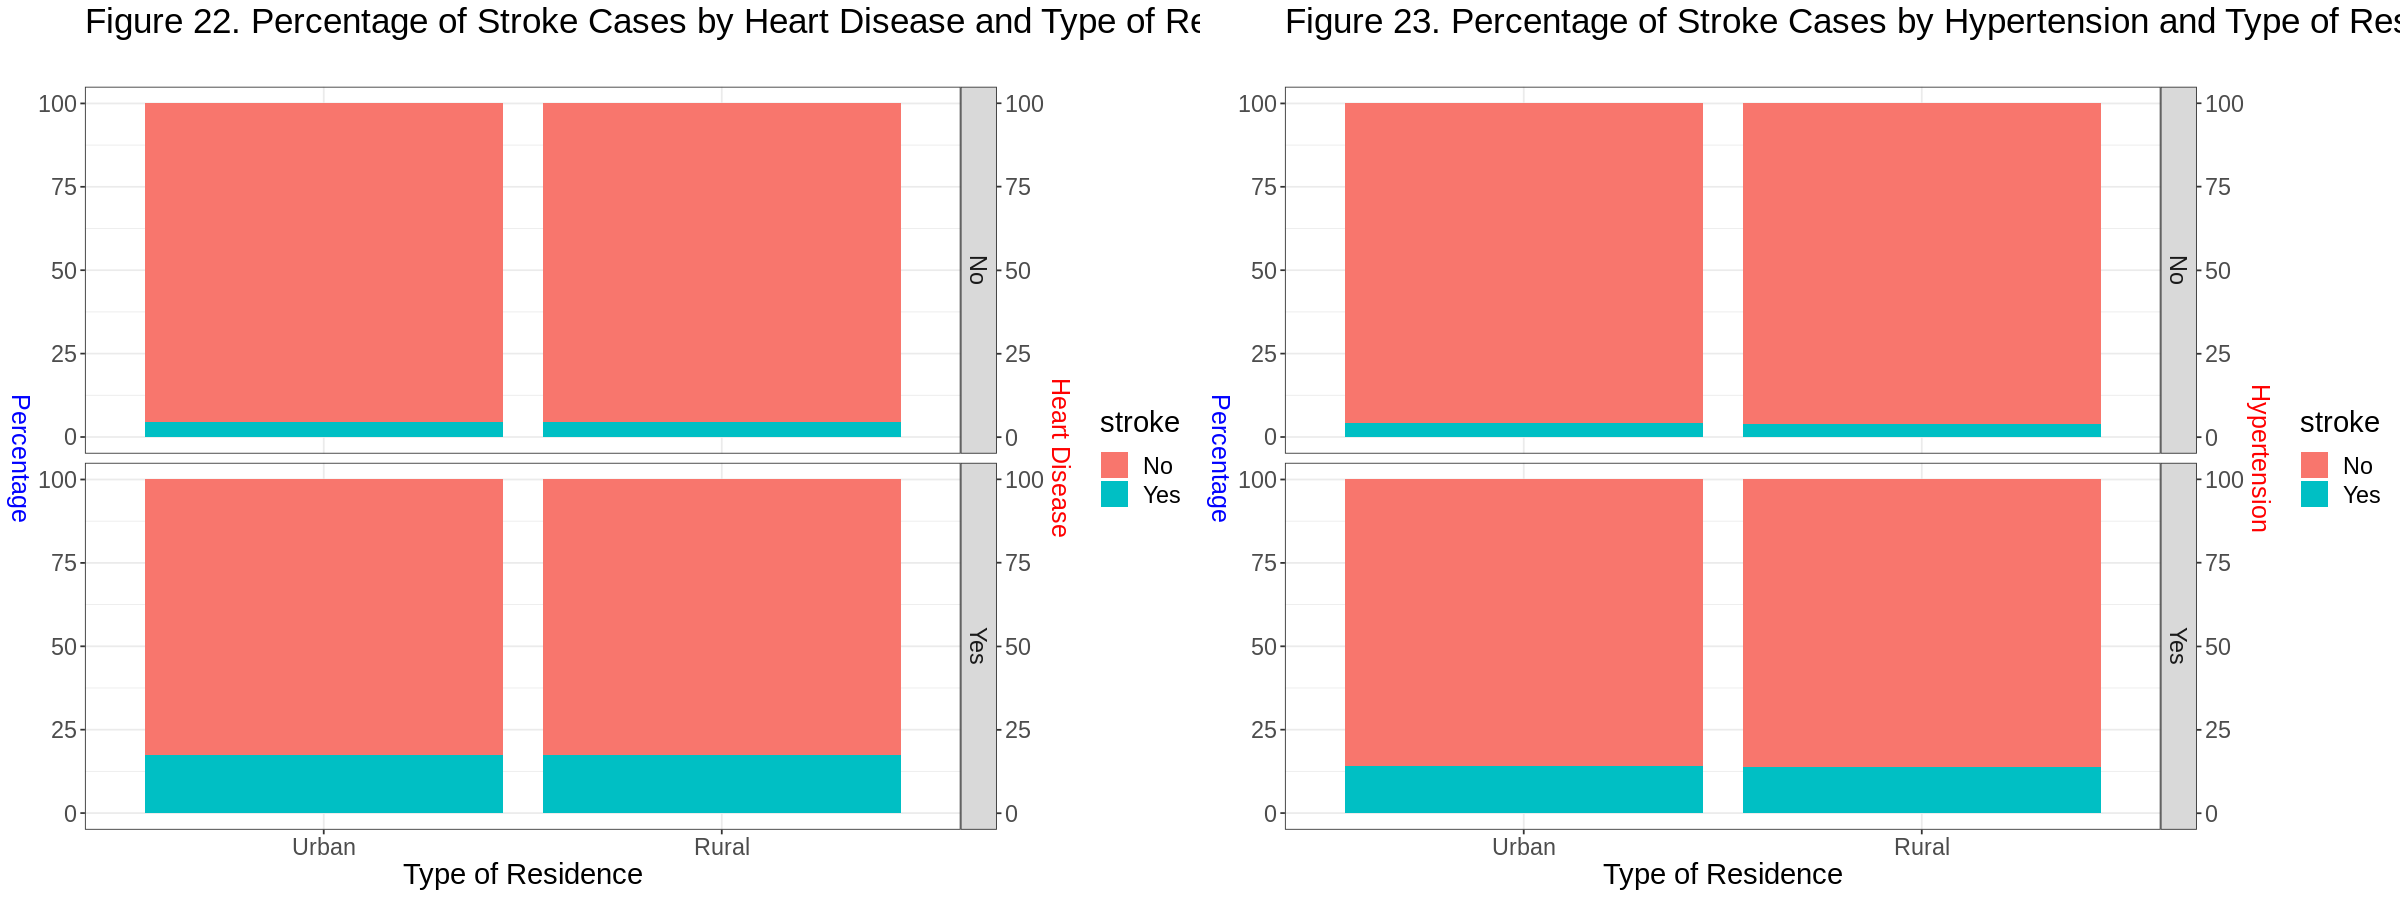

In [161]:
options(repr.plot.width = 10, repr.plot.height = 7.5) 

heartdisease_residence <- stroke %>%
  count(residence_type, stroke, heart_disease) %>%
  group_by(residence_type,heart_disease) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ungroup()

heartdisease_residence <- heartdisease_residence %>%
    ggplot(aes(x = residence_type, y = percentage, fill = stroke)) +
      geom_bar(stat = "identity") +
      labs(x = "Type of Residence", y = "", title = "Figure 22. Percentage of Stroke Cases by Heart Disease and Type of Residence\n") +
      facet_grid(heart_disease ~ .) +
      theme_bw() +
      theme(
        axis.title.y.right = element_text(color = "red", size = 15, angle = -90, vjust = 0.5),
        axis.title.y.left = element_text(color = "blue", size = 15, angle = -90, vjust = 0.5)
      ) +
      theme(text = element_text(size = 17.5),
        plot.title = element_text(hjust = 0))+
      scale_y_continuous(
        name = "Percentage",
        sec.axis = sec_axis(~ ., name = "Heart Disease")
      )

hypertension_residence <- stroke %>%
  count(residence_type, stroke, hypertension) %>%
  group_by(residence_type,hypertension) %>%
  mutate(percentage = n / sum(n) * 100) %>%
  ungroup()

hypertension_residence <- hypertension_residence %>%
    ggplot(aes(x = residence_type, y = percentage, fill = stroke)) +
      geom_bar(stat = "identity") +
      labs(x = "Type of Residence", y = "", title = "Figure 23. Percentage of Stroke Cases by Hypertension and Type of Residence\n") +
      facet_grid(hypertension ~ .) +
      theme_bw() +
      theme(
        axis.title.y.right = element_text(color = "red", size = 15, angle = -90, vjust = 0.5),
        axis.title.y.left = element_text(color = "blue", size = 15, angle = -90, vjust = 0.5)
      ) +
      theme(text = element_text(size = 17.5),
        plot.title = element_text(hjust = 0))+
      scale_y_continuous(
        name = "Percentage",
        sec.axis = sec_axis(~ ., name = "Hypertension")
      )

options(repr.plot.width = 20, repr.plot.height = 7.5) 

grid.arrange(heartdisease_residence, hypertension_residence, ncol = 2)

##### Stroke Cases by Type of Residence and Heart Disease
The instances of stroke are roughly equal for those who have not experienced heart disease, regardless of their type of residence. Cases of strokes are also roughly equal between those who have experienced heart disease, regardless of their residence type. Most cases of no stroke are prevalent in those who did not experience heart disease and overall, there is a higher occurrence of strokes for those who have experienced heart disease.

##### Stroke Cases by Residence Type and Hypertension
Regardless of one’s residence type, cases of strokes are roughly equal when one experiences hypertension. The prevalence of strokes in those who did not have hypertension is also equal in both urban and rural areas, and most cases of no stroke are present in those who do not have hypertension.

This suggests that hypertension and heart disease are likely a stronger predictor of stroke than the type of residence one resides in.


### Exploring Excluded Variables

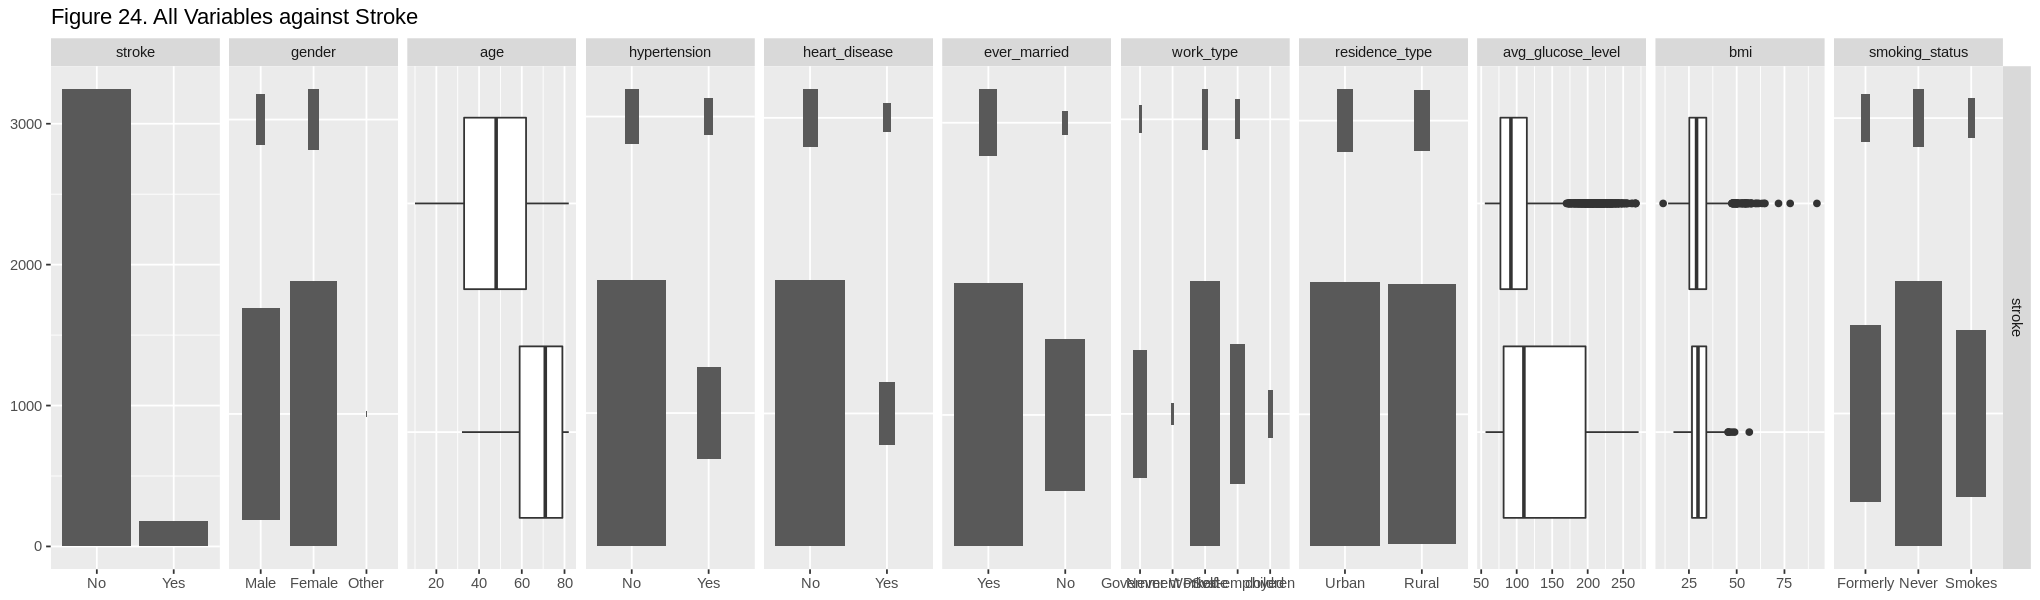

In [168]:
options(repr.plot.height = 5, repr.plot.width = 17)

pm_pairs <- stroke %>%
  select(stroke, gender:stroke) %>%
  ggpairs() + ggtitle("Figure 24. All Variables against Stroke")

pm_pairs$nrow <- 1
pm_pairs$yAxisLabels <- pm_pairs$yAxisLabels[1]
print(pm_pairs)

Let's explore and see if `ever_married` and/or `work_type` have a significant influence on the classification. Here we are defining four different `formulas`: the first one excludes both `ever_married` and `work_type`, the second includes `ever_married` but excludes `work_type`, the third one excludes `ever_married`, and our last formula includes both of them.

To determine if these are useful predictors, we will train several `k-nearest neighbor` classification models and compare their accuracies.

In [90]:
names <- colnames(stroke_training |> select(-work_type, -ever_married, -stroke))
base_formula_string <- paste("stroke", "~", paste(names, collapse="+"))
formulas = c(base_formula_string,
             paste(base_formula_string, "+ever_married"),
             paste(base_formula_string, "+work_type"),
             paste(base_formula_string, "+ever_married+work_type"))

In the code above, we define the `knn` model classification and set-up 5-fold cross-validation for our models. This involves further splitting up our training data into two pieces - one part for training and one part for evaluation. By repeatedly splitting our original training data into a training and validation split, we can evaluate several different values of k (or the number of neighbors) used in our model. Furthermore, by evaluating the accuracy of the model several times, we can be sure that our results were not simply due to luck or random chance.

In [91]:
stroke_classifier <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")

In [92]:
stroke_vfold <- vfold_cv(stroke_training, v = 5, strata = stroke)

We set-up some scaffolding for the various models to be trained:

In [93]:
#Create table of accuracies
accs <- data.frame(matrix(ncol = 3, nrow = 0))
x <- c("neighbors", "mean", "model_string")
colnames(accs) <- x
accs <- accs |> mutate(across(neighbors, as.integer)) |> mutate(across(mean, as.double)) |> mutate(across(model_string, as.character))

For each of our four formulas, we define a `recipe` - this recipe describes what we are trying to predict (stroke), what are our prediction variables (defined in each respective formula), what is our dataset (the training set is used for this task) and how we will scale the data. Scaling is an important step in the k-nn algorithm as it computes similarity using a distance metric - having features on a similar scale allows the algorithm to make fair comparisons.

Following this, we define a `workflow` - this involves a processing called *tuning*, where we define a grid of possible values for `k` (the number of neighbors used to make a classification). We repeatedly develop a classification model with a range of `k` (from `k=1` to `k=20`) and select the value of `k` that results in the highest accuracy by using a combination of `collect_metrics` (which outputs the metrics for each `k` trained) and we `filter` on the value that gives us the highest accuracy.

In [94]:
set.seed(123)
for (formula in formulas) {
    # create a recipe from the model string
    stroke_recipe <- recipe(as.formula(formula), data = stroke_training) |> 
        step_scale(all_numeric_predictors()) |> 
        step_center(all_numeric_predictors()) |>
        step_dummy(all_nominal_predictors())
    
    # tune the KNN classifier with these predictors, 
    # and collect the accuracy for the best K
    k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
    acc <- workflow() |>
      add_recipe(stroke_recipe) |>
      add_model(stroke_classifier) |>
      tune_grid(resamples = stroke_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      arrange(desc(mean)) |> head(1) |> # the row with the highest accuracy
      select(neighbors, mean) |> 
      mutate(model_string = formula)
    accs <- add_row(accs, acc)
}

The end result is a data frame with four rows, each row has three columns: `neighbors` which is the # of neighbors that resulted in the highest accuracy for the given formula, `mean` the mean accuracy for the model and `model_string` which describes which predictors were used in creating the model.

In [95]:
accs

neighbors,mean,model_string
<dbl>,<dbl>,<chr>
11,0.9481752,stroke ~ gender+age+hypertension+heart_disease+residence_type+avg_glucose_level+bmi+smoking_status
11,0.9481752,stroke ~ gender+age+hypertension+heart_disease+residence_type+avg_glucose_level+bmi+smoking_status +ever_married
7,0.9485401,stroke ~ gender+age+hypertension+heart_disease+residence_type+avg_glucose_level+bmi+smoking_status +work_type
7,0.9489051,stroke ~ gender+age+hypertension+heart_disease+residence_type+avg_glucose_level+bmi+smoking_status +ever_married+work_type


As seen, the variables `ever_married` and `work_type` do not have any effect on the accuracy of the model. This is corroborated by the weak correlation obtained in the preliminary correlation chart. Hence, these variables will be excluded to improve model efficiency.

# Building The Model
As a result of our data analysis, we will be moving forwards with these features as predictors of stroke:
(Note: the follwowing should be tables)
| Predictors             | Definition                                              |
|------------------------|---------------------------------------------------------|
| Gender                 | Whether the person is Male or Female                    |
| Age                    | Age of patient                                          |
| Hypertension           | Diagnosed with hypertension or not                      |
| Heart Disease          | Diagnosed with heart disease or not                     |
| Residence              | Living in rural or urban area                           |
| Average glucose levels | Average glucose level in blood [mg/dL]                  |
| BMI                    | Body mass index                                         |
| Smoking status         | Current smoker, former smoker, or never smoked          |
| Stroke                 | Has had a stroke before or not                          |

And these are the features we will not be using in our analysis:
| Unused Predictors | Definition And Justification For Not Using                                       |
|-------------------|--------------------------------------------------------------------------------------|
| id                | ID of patient; does not contribute to stroke prediction                             |
| ever_married      | Ever married or not; this is too broad of a predictor*                             |
| work_type         | Either “Private”, “Self-Employed”, “Government job”, “Never worked”, “Children”; options are too broad** |

*There were no research findings in relation to whether someone is married or not that is predictive of stroke. Furthermore, the question of whether someone is married or not does not take into account marital satisfaction, which at least for men, “low marital satisfaction increases long term risk of stroke and all-cause mortality” (Lev-ari, Gepner, & Goldbourt, 2021).

**We believe that the options for work_type are not sufficient to accurately predict stroke. A lot of questions that arise with the lack of specificity of these options. For example, for those who are “self-employed”, aspects such as income and whether or not they work another job are key pieces of information that are missing which would be better predictors of stress, as stated in Wang et al (2019), where researchers found that high SES is positively related to the risk of stroke. For work type, we feel that the options “white collar” and “blue collar” jobs are a better way to classify the type of work the patients do, as there were findings suggesting that white collar workers had a 20% higher risk of hypertension, the leading risk factor of stroke, compared to blue collar workers (Liu et al., 2017).

Now that we have finalized the features that will be used in the model, let's define the final `recipe` that we will be using - we scale the predictors as described above:

In [96]:
stroke_recipe <- recipe(stroke ~ gender+age+hypertension+heart_disease+residence_type+avg_glucose_level+bmi+smoking_status, data = stroke_training) |> 
            step_scale(all_numeric_predictors()) |> 
            step_center(all_numeric_predictors()) |>
            step_dummy(all_nominal_predictors())

During our analysis above, we ran a 5-fold cross-validation across a grid of values for `k` (# of neighbors) from 1 to 20. It was found that `k=19` results in the highest accuracy on our training dataset. We will use this value to develop our final model with `neighbors = 19`.

In [97]:
stroke_model_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |> set_engine("kknn") |> set_mode("classification")

We train our final model and fit it against our training dataset.

In [98]:
stroke_fit <- workflow() |> add_model(stroke_model_final) |> add_recipe(stroke_recipe) |> fit(data = stroke_training)

We used the model trained with the optimal number of neighbors, and then use it to predict new values using our test set:

In [99]:
stroke_test_predictions <- predict(stroke_fit, stroke_testing) |> bind_cols(stroke_testing)

Lastly, we can calculate the accuracy of our predictions on the test set. This is a representation of how our model generalizes to new, unseen predictions.

In [100]:
model_metrics <- stroke_test_predictions |> metrics(truth = stroke, estimate = .pred_class)
model_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9446064
kap,binary,0.0000000


As seen from the `accuracy` metric above, the model is able to predict if a person has experienced a stroke with an accuracy of `94.5%`. Whilst this is a promising result in attempting to create a model which will predict whether a person will have a stroke, this is no indication that the model generated will be able to **predict** a stroke with a sufficient accuracy.

In [101]:
confusion <- stroke_test_predictions |>
             conf_mat(truth = stroke, estimate = .pred_class)
confusion

          Truth
Prediction  No Yes
       No  648  38
       Yes   0   0

However, upon inspection of the confusion matrix for the model, we discover a flaw. The model seems to be classifying every single case as no stroke. The model may be rewarded when doing so as the percentage of people with a stroke is so low, the penalization is also low. In order to remedy this, we must rectify the model to be more heavily penalized for these Type II errors. Type II errors are the most dangerous as in our desired application, it would lead to the model stating that the participant will not have a stroke. In actualality, they will and that may lead to a sense of false confidence which decreases their alertness for signs/precursors of stroke. The issue with k-nearest neighbors and heavily imbalanced datasets has been well documented. Efforts were attempted in using a different evaluation metric, such as the F2 score, but similar problems were encountered, most likely due to the heavy imbalance of the dataset.

# Discussion

The following sections are beyond the scope of the course, but it would be interesting to see if another form of classification algorithm would be useful in working with this extremely unbalanced dataset. We will be using the Random Forest algorithm in this case. The following section is adapted from https://juliasilge.com/blog/sf-trees-random-tuning/

In [102]:
stroke_recipe <- recipe(stroke ~ gender+age+hypertension+heart_disease+residence_type+avg_glucose_level+bmi+smoking_status, data = stroke_training) |> 
            step_dummy(all_nominal_predictors(), -all_outcomes())
stroke_prep <- prep(stroke_recipe)
juiced <- juice(stroke_prep)

In [103]:
forest_model <- rand_forest(mtry = tune(), trees = 1000, min_n = tune()) |> set_engine("ranger") |> set_mode("classification")

In [104]:
forest_tune_workflow <- workflow() |> add_recipe(stroke_recipe) |> add_model(forest_model)

In [105]:
set.seed(1000)
stroke_vfold <- vfold_cv(stroke_training, v = 5, strata = stroke)

In [106]:
tune_results <- tune_grid(forest_tune_workflow, resamples = stroke_vfold, grid = 20)

i Creating pre-processing data to finalize unknown parameter: mtry



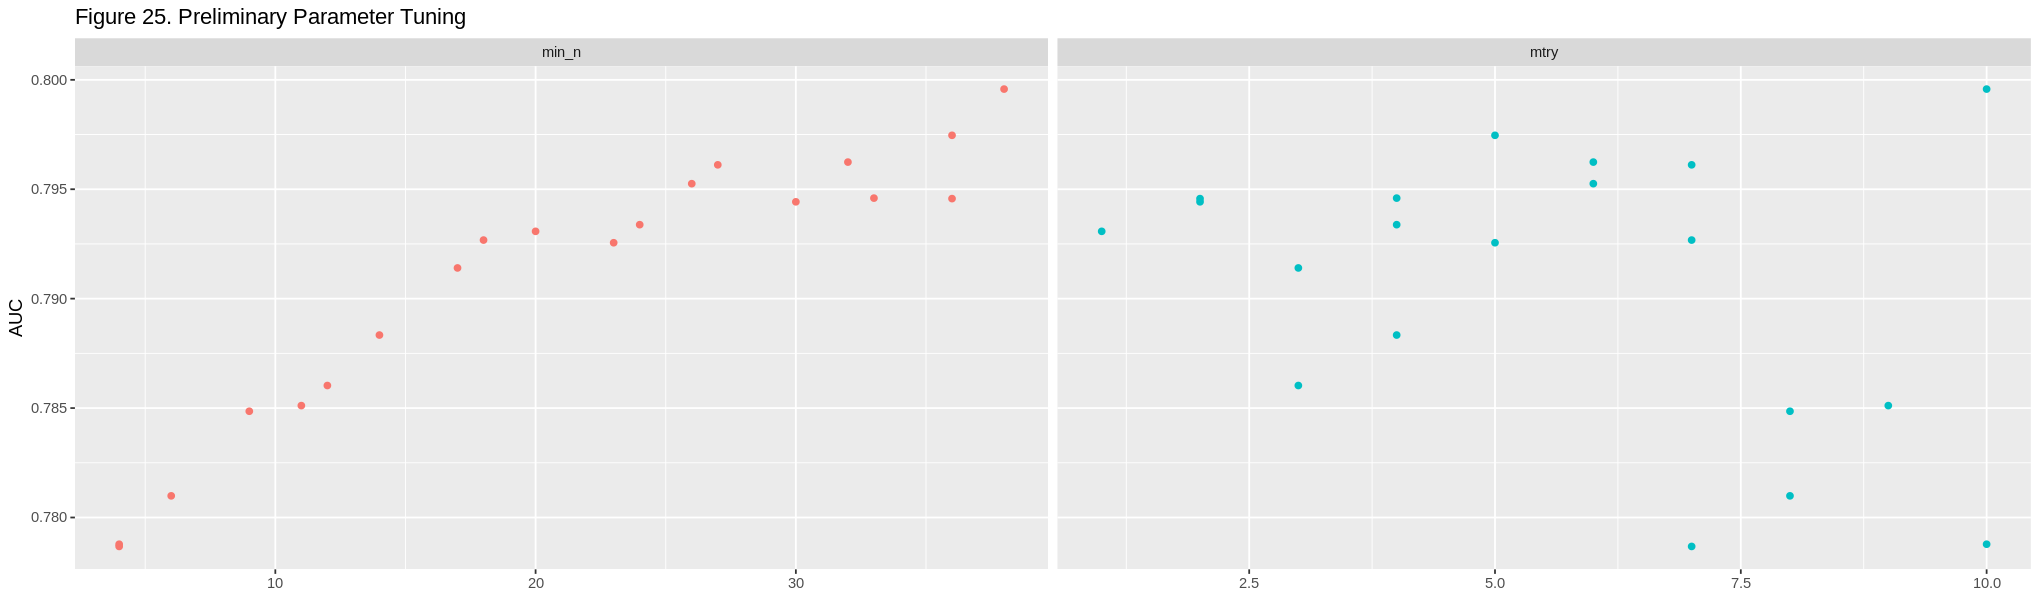

In [173]:
tune_results |>
  collect_metrics() |>
  filter(.metric == "roc_auc") |>
  select(mean, min_n, mtry) |>
  pivot_longer(min_n:mtry,
    values_to = "value",
    names_to = "parameter"
  ) |>
  ggplot(aes(value, mean, color = parameter)) +
  geom_point(show.legend = FALSE) +
  facet_wrap(~parameter, scales = "free_x") +
  labs(x = NULL, y = "AUC", title = "Figure 25. Preliminary Parameter Tuning")

It seems that the model works well with around 5-10 predictors and with a `min_n` of above 30. We will now try tuning again with these ranges

In [108]:
rf_grid <- grid_regular(
  mtry(range = c(5, 10)),
  min_n(range = c(30, 50)),
  levels = 5
)

regular_res <- tune_grid(
  forest_tune_workflow,
  resamples = stroke_vfold,
  grid = rf_grid
)


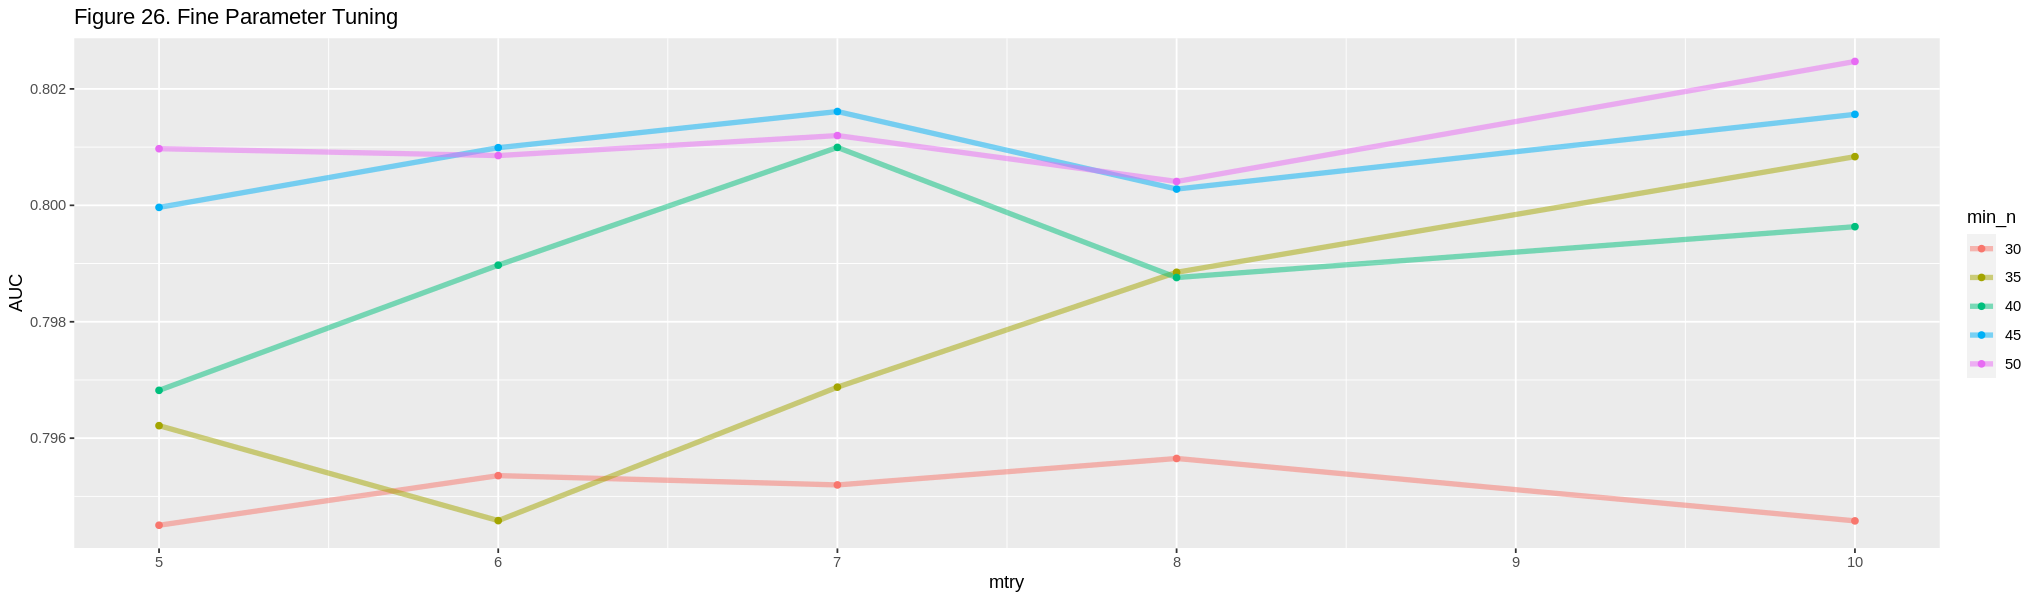

In [171]:
regular_res %>%
  collect_metrics() %>%
  filter(.metric == "roc_auc") %>%
  mutate(min_n = factor(min_n)) %>%
  ggplot(aes(mtry, mean, color = min_n)) +
  geom_line(alpha = 0.5, size = 1.5) +
  geom_point() +
  labs(y = "AUC", title = "Figure 26. Fine Parameter Tuning")

It appears we have hit the upper limit for the improvements to AUC with increasing `min_n` whereby an increase in `min_n` does not result in a significant increase in `AUC`, leading us to the final parameters of `min_n = 45` and `mtry = 10`

In [110]:
best_auc <- select_best(regular_res, "roc_auc")

final_rf <- finalize_model(
  forest_model,
  best_auc
)

final_rf

Random Forest Model Specification (classification)

Main Arguments:
  mtry = 10
  trees = 1000
  min_n = 50

Computational engine: ranger 


In [111]:
final_wf <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(final_rf)

final_res <- final_wf %>%
  last_fit(stroke_split)

final_res %>%
  collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.9446064,Preprocessor1_Model1
roc_auc,binary,0.7923164,Preprocessor1_Model1


In [112]:
predictions <- final_res |> collect_predictions()

In [113]:
confusion_forest <- predictions |>
             conf_mat(truth = stroke, estimate = .pred_class)
confusion_forest

          Truth
Prediction  No Yes
       No  648  38
       Yes   0   0

Unfortunately, this model also encounters issues similar to to the knn algorithm.

The research project aimed to accurately predict the occurrence of stroke in patients based on a set of clinical features. The researchers utilized the Stroke Prediction Dataset, which included information on 12 variables, such as age, gender, hypertension, heart disease, average glucose levels, BMI, smoking status, and more. By analyzing this dataset, the researchers identified patterns between these clinical features and the occurrence of stroke.

Through the primary analysis, age and hypertension emerged as the strongest predictors of stroke. Age was determined to be the primary determinant of stroke risk, with the likelihood of experiencing a stroke doubling every decade after the age of 55. Hypertension, or high blood pressure, was also identified as a leading risk factor for stroke. Other factors, such as heart disease, BMI, average glucose levels, smoking status, and type of work, showed varying degrees of association with stroke occurrence.

Visualizations and exploratory data analysis played a crucial role in identifying correlations between the clinical variables and stroke. For instance, it was observed that individuals above the age of 60 were approximately twice as likely to suffer a stroke compared to those in their mid to late 40s. Similarly, participants with hypertension or heart disease were at an increased risk of stroke. BMI and average glucose levels were found to have a positive association with stroke cases.

However, the research did not yield the expected results. Surprisingly, the models used, including the one discussed, classified everything as "No" stroke. This discrepancy could be attributed to the lower correlations of the variables with stroke compared to what was originally anticipated based on previous literature. These findings suggest that to develop a more accurate model, additional factors beyond those present in our dataset, such as genetic factors/family history and lifestyle choices, need to be considered.

## Potential Limitations of Our Model
Our current classification model, based on k-nearest neighbors (KNN), has certain limitations that should be considered. Instead of predicting stroke occurrence, it focuses on determining whether a person has had a stroke based on the predictors utilized in our analysis. One limitation is that the dataset used represents a snapshot of stroke cases at a specific point in time. This can potentially limit its generalizability to future cases. Changes in stroke occurrence after the data collection period could affect the predictive power of the model. Additionally, our model does not account for potential risk factors that were not included in the dataset but may contribute to stroke occurrence. Their absence in the analysis may affect the accuracy of our predictions. To address these limitations, it may be beneficial to incorporate data from before the stroke event and establish a timeline to track the changes in clinical features over time. This approach could enhance our understanding of stroke occurrence and improve the accuracy of future classification models.

## Impact of Our Findings

### Early Intervention
By being able to predict stroke risks, healthcare providers can better identify individuals who are at a higher risk of stroke before the deadly event happens. Early identification has the potential to significantly reduce the occurrence of strokes and further complications by allowing individuals to develop personalized treatment plans with medical professionals to improve their quality of life.
### Education and Awareness
Our findings can be used to educate future generations of the risk factors that are associated with having a stroke. This can encourage them to live a healthier and more positive lifestyle. As well, this may offer those who have risk factors that are genetic and not lifestyle related, a better understanding of their risks. This will also benefit policy making. For example, if the model identifies smoking as a strong predictor of a stroke, people in public health can prioritize initiatives that better control smoking and be more specfic in their messages regarding the long term effects.
## What future questions could this lead to?
One key area for future exploration is the generalizability of the model in real-word scenarios. This is specifically important in the event of insurance companies or governments deciding to use this technology in order to push their specific agendas. This may lead to unfair outcomes that discriminate or present biases based on the demographic of the original sample it was trained with. As refined and well-trained the model can be, it is crucial to consider the potential exceptions and variations that arise due to the oddities of human biology and environmental factors. Therefore this research can lead to future studies that focus on assessing the models ability across various populations. Other areas that can be explored are specific aspects of the predictors explored in this analysis. For example, one of our predictors is BMI, which is shown to be linked to all-cause mortality. However, BMI does not differentiate between fat mass and muscle mass (Cheung et al, 2015). Considering muscle mass is inversely associated with mortality (Lee & Giovannucci, 2018), researchers may want to see to what degree does fat mass associate with all-cause mortality, and in our specific case, stroke.

# References 


Cheung, C., Lee, G. K., Au, P. C., Li, G. H., Chan, M., Li, H., Cheung, B. M., Wong, I. C., Lee, V. H., Mok, J., Yip, B. H., Cheng, K. K., & Wu, C. (2021). Systematic review and meta-analysis of lean mass and mortality: Rationale and study description. Osteoporosis and Sarcopenia, 7(Suppl 1), S3-S12. https://doi.org/10.1016/j.afos.2021.01.001

Lee, D. H., & Giovannucci, E. L. (2018). Body composition and mortality in the general population: A review of epidemiologic studies. Experimental biology and medicine (Maywood, N.J.), 243(17-18), 1275–1285. https://doi.org/10.1177/1535370218818161

Lev-Ari, S., Gepner, Y., & Goldbourt, U. (2021). Dissatisfaction with Married Life in Men Is Related to Increased Stroke and All-Cause Mortality. Journal of clinical medicine, 10(8), 1729. https://doi.org/10.3390/jcm10081729

Liu, X., Liu, C., Schenck, H., Yi, X., Wang, H., & Shi, X. (2017). The risk factors of 9-year follow-up on hypertension in middle-aged people in Tujia-Nationality settlement of China. Journal of human hypertension, 31(12), 838–842. https://doi.org/10.1038/jhh.2017.58

NCI Dictionary of Cancer terms. National Cancer Institute. (n.d.). http://www.cancer.gov/publications/dictionaries/cancer-terms/def/stroke 

Shah, R. S., & Cole, J. W. (2010). Smoking and stroke: the more you smoke the more you stroke. Expert review of cardiovascular therapy, 8(7), 917–932. https://doi.org/10.1586/erc.10.56 

Wang, S., Shen, B., Wu, M., Chen, C., & Wang, J. (2019). Effects of socioeconomic status on risk of ischemic stroke: A case-control study in the guangzhou population. BMC Public Health, 19(1), 648-648. https://doi.org/10.1186/s12889-019-6998-4